<a href="https://colab.research.google.com/github/pedro-otl/TECHCHALLENGE_GRUPO_2/blob/main/Tech_Challenge_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tech Challenge 2
**Objetivo** - Desenvolver um modelo de machine learning para prever a tendência diária (alta ou baixa) do índice IBOVESPA com pelo menos 75% de acurácia.

**Base de dados:** https://drive.google.com/file/d/1wOCuinXsWad-Wf6OxL7LIUcdtRr2xamO/view?usp=sharing

**Período:** 03/10/2005 - 15/10/2025

# Instalação e Importação de Bibliotecas

In [ ]:
!pip install statsmodels==0.14.0 scipy==1.11.4

In [ ]:
!pip install pmdarima

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix)
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier

from typing import Tuple

import matplotlib.pyplot as plt
import numpy  as np
import pandas as pd
import seaborn as sns
import warnings
import xgboost as xgb

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score

from prophet import Prophet
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
)
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, accuracy_score, classification_report
from sklearn.preprocessing import MinMaxScaler

from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

from statsmodels.graphics.tsaplots import plot_acf as _plot_acf
from statsmodels.graphics.tsaplots import plot_pacf as _plot_pacf

# Funções de Suporte

In [ ]:
def grafico_predicao(y_test, y_pred, df_test,
                     date_format='%d/%m',
                     title='Comparação Entre Valores Reais e Valores Preditos',
                     show_metrics=True,
                     highlight_mistakes=True,
                     figsize=(14,7),
                     alpha_real=0.15,
                     alpha_pred=0.85):


  # Métricas
  acc = accuracy_score(y_test, y_pred)
  prec = precision_score(y_test, y_pred, zero_division=0)
  rec = recall_score(y_test, y_pred, zero_division=0)
  f1 = f1_score(y_test, y_pred, zero_division=0)
  clf_report = classification_report(y_test, y_pred, digits=4, zero_division=0)

  # Preparação para plot - Mapeamos 0 = -1, 1 = +1
  plot_vals_true = np.where(y_test == 1, 1, -1)
  plot_vals_pred = np.where(y_test == 1, 1, -1)

  # Eixo x: índice formatado
  if df_test is not None:
    try:
        idx = df_test.index
        x_labels = idx
        x_pos = np.arange(len(idx))
        use_dates = isinstance(idx, pd.DatetimeIndex)
    except Exception:
        x_pos = np.arange(n)
        x_labels = x_pos
        use_dates = False
  else:
    x_pos = np.arange(n)
    x_labels = x_pos
    use_dates = False


  # Plot
  plt.figure(figsize=figsize)
  ax = plt.gca()
  ax.axhline(0, color='grey', lw=1, linestyle='--')

  offset = 0.12  # separação entre real e predito no x para visualização

  # Real: linhas e pontos
  ax.vlines(x_pos - offset, 0, plot_vals_true, color='tab:green', alpha=alpha_real, label='Real')
  ax.scatter(x_pos - offset, plot_vals_true, color='tab:green', s=48, edgecolor='k', linewidth=0.3)

  # Predito: linhas e pontos
  ax.vlines(x_pos + offset, 0, plot_vals_pred, color='tab:blue', alpha=alpha_pred, label='Predição')
  ax.scatter(x_pos + offset, plot_vals_pred, color='tab:blue', s=48, edgecolor='k', linewidth=0.3)

  # Destacar erros
  if highlight_mistakes:
    mistakes = (y_test != y_pred)

    if np.any(mistakes):
        fp = (y_pred == 1) & (y_test == 0)
        fn = (y_pred == 0) & (y_test == 1)

        # marcador para FP: triângulo para cima na posição da predição
        ax.scatter(x_pos[fp] + offset, plot_vals_pred[fp], marker='^', s=120, facecolors='none', edgecolors='black', linewidths=1.2, label='Falso Positivo (FP)')

        # marcador para FN: triângulo para baixo
        ax.scatter(x_pos[fn] + offset, plot_vals_pred[fn], marker='v', s=120, facecolors='none', edgecolors='black', linewidths=1.2, label='Falso Negativo (FN)')

  # Ajustes estéticos
  ax.set_yticks([-1, 1])
  ax.set_yticklabels(['0 (Negativo)', '1 (Positivo)'])
  ax.set_ylim(-1.5, 1.5)
  ax.set_xticks(x_pos)

  if use_dates:
    # Formatar datas para string legíveis
    ax.set_xticklabels([d.strftime(date_format) for d in x_labels], rotation=90, fontsize=8)
  else:
    ax.set_xticklabels([str(x) for x in x_labels], rotation=90, fontsize=8)

  ax.set_xlabel('Data' if use_dates else 'Índice')
  ax.set_ylabel('Classe')
  ax.set_title(title)
  ax.legend(loc='upper right')
  ax.grid(True, axis='x', alpha=0.25)
  plt.tight_layout()
  plt.show()

  # Impressão de métricas
  if show_metrics:
    print("\nMétricas de Classificação")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print("\nClassification report:\n")
    print(clf_report)

In [ ]:
# Calcula e plota a importância dos atributos (features) para o modelo
def importancia_features(X_train, model):

    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': model.feature_importances_
    }).sort_values('Importance', ascending=False)

    print("Importância das Features")
    print(feature_importance.to_string())

    # Gráfico de importância das features
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['Feature'], feature_importance['Importance'])
    plt.xlabel('Importância')
    plt.title('Importância das Features no Modelo')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

In [ ]:
# Função para conversão da coluna de volume
def converter_volume(valor):
    valor = str(valor).replace(',', '.')
    if 'B' in valor:
        return float(valor.replace('B','')) * 1e9
    elif 'M' in valor:
        return float(valor.replace('M','')) * 1e6
    elif 'K' in valor:
        return float(valor.replace('K','')) * 1e3
    else:
        return float(valor)

# Carregamento e Limpeza dos Dados

In [ ]:
# Carregando a série de dados
file_id = "1wOCuinXsWad-Wf6OxL7LIUcdtRr2xamO"
url = f"https://drive.google.com/uc?export=download&id={file_id}"

df = pd.read_csv(url, sep=',')

In [ ]:
# Visualização das primeiras linhas do DataFrame
df.head(30)

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,15.10.2025,142.604,141.683,142.905,141.154,"10,32B","0,65%"
1,14.10.2025,141.683,141.788,142.589,141.334,"7,12B","-0,07%"
2,13.10.2025,141.783,140.682,142.303,140.682,"5,53B","0,78%"
3,10.10.2025,140.680,141.725,142.274,140.231,"8,28B","-0,73%"
4,09.10.2025,141.708,142.148,143.212,141.603,"6,82B","-0,31%"
5,08.10.2025,142.145,141.356,142.385,141.356,"7,53B","0,56%"
6,07.10.2025,141.356,143.606,143.606,141.035,"9,27B","-1,57%"
7,06.10.2025,143.608,144.202,144.532,143.376,"5,98B","-0,41%"
8,03.10.2025,144.201,143.950,144.518,143.676,"6,18B","0,17%"
9,02.10.2025,143.950,145.517,145.621,143.635,"7,25B","-1,08%"


In [ ]:
# Renomeação das colunas para padrão e consistência
df = df.rename(columns={
    'Data': 'data', 'Último': 'fechamento', 'Abertura': 'abertura',
    'Máxima': 'max', 'Mínima': 'min', 'Vol.': 'volume', 'Var%': 'var'
})

In [ ]:
# Conversão da coluna 'data' para o tipo datetime
df['data'] = pd.to_datetime(df['data'], format='%d.%m.%Y')

In [ ]:
# Definição da coluna 'data' como índice e ordenação
df = df.set_index('data').sort_index(ascending=True)

In [ ]:
# Remove e substituição de caracteres
df['var'] = df['var'].str.replace('%','').str.replace(',','.').astype(float)

In [ ]:
# Aplicando a função de conversão na coluna 'volume'
df['volume'] = df['volume'].apply(converter_volume)

In [ ]:
# Verificação de valores nulos
df.isnull().sum()

,0
fechamento,0
abertura,0
max,0
min,0
volume,1
var,0


In [ ]:
# Tratamento de valor nulo com a mediana
df['volume'] = df['volume'].fillna(df['volume'].median())

A estratégia de utilizar mediana para preencher o valor faltante da coluna 'volume' evita distorções por outliers ou na distribuição da série de dados

In [ ]:
# Verificação dos tipos de dados
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4964 entries, 2005-10-03 to 2025-10-15
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   fechamento  4964 non-null   float64
 1   abertura    4964 non-null   float64
 2   max         4964 non-null   float64
 3   min         4964 non-null   float64
 4   volume      4964 non-null   float64
 5   var         4964 non-null   float64
dtypes: float64(6)
memory usage: 271.5 KB


# Análise Exploratória dos Dados

In [ ]:
# Análise estatística descritiva dos dados
df.describe().T

,count,mean,std,min,25%,50%,75%,max
fechamento,4964.0,7.638108e+01,3.002571e+01,28.344,5.327225e+01,6.502850e+01,1.043745e+02,1.464920e+02
abertura,4964.0,7.635921e+01,3.001775e+01,28.346,5.326600e+01,6.501550e+01,1.043680e+02,1.464920e+02
max,4964.0,7.707766e+01,3.016358e+01,29.176,5.391400e+01,6.563750e+01,1.051817e+02,1.475780e+02
min,4964.0,7.565392e+01,2.988736e+01,28.161,5.273575e+01,6.443350e+01,1.034522e+02,1.460670e+02
volume,4964.0,3.868118e+08,1.897379e+09,112100.000,2.820000e+06,4.440000e+06,1.089000e+07,2.487000e+10
var,4964.0,4.400685e-02,1.648575e+00,-14.780,-7.900000e-01,6.000000e-02,9.100000e-01,1.466000e+01


Text(0, 0.5, 'Variação do Valor (%)')

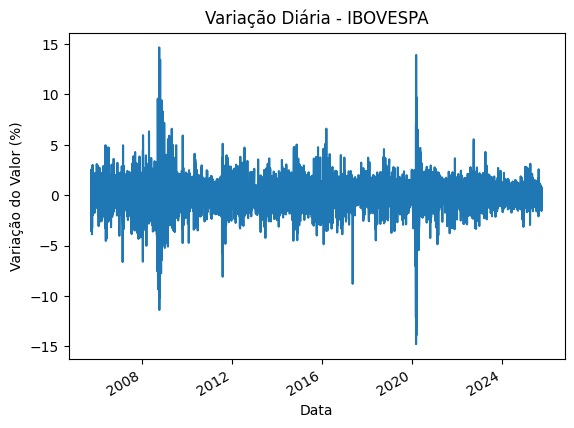

In [ ]:
# Visualização da variação diária do IBOVESPA
df['var'].plot(kind='line')

plt.title("Variação Diária - IBOVESPA")
plt.xlabel("Data")
plt.ylabel("Variação do Valor (%)")


Text(0, 0.5, 'Valor de Fechamento')

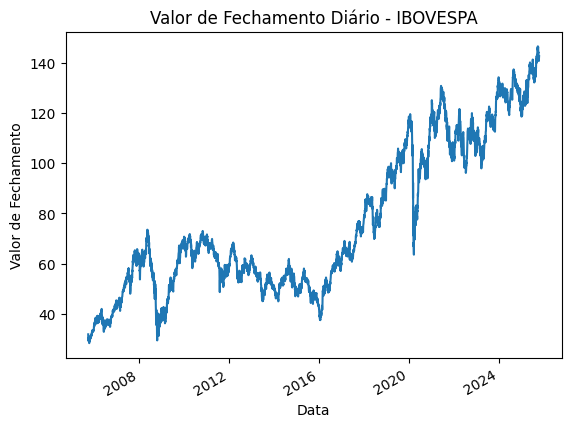

In [ ]:
# Visualização do valor de fechamento diário do IBOVESPA
df['fechamento'].plot(kind='line')

plt.title("Valor de Fechamento Diário - IBOVESPA")
plt.xlabel("Data")
plt.ylabel("Valor de Fechamento")

Text(0, 0.5, 'Valor de Abertura')

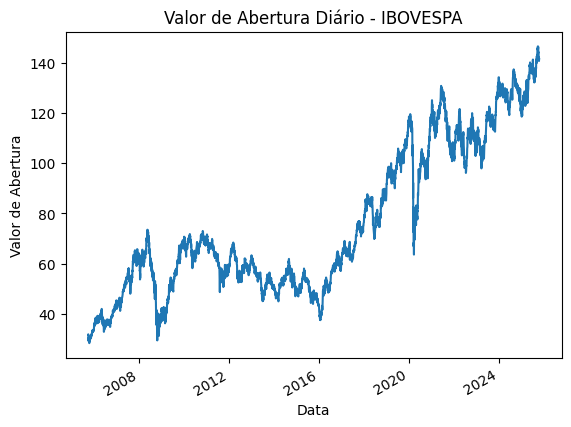

In [ ]:
# Visualização do valor de abertura diário do IBOVESPA
df['abertura'].plot(kind='line')

plt.title("Valor de Abertura Diário - IBOVESPA")
plt.xlabel("Data")
plt.ylabel("Valor de Abertura")

Text(0, 0.5, 'Valor')

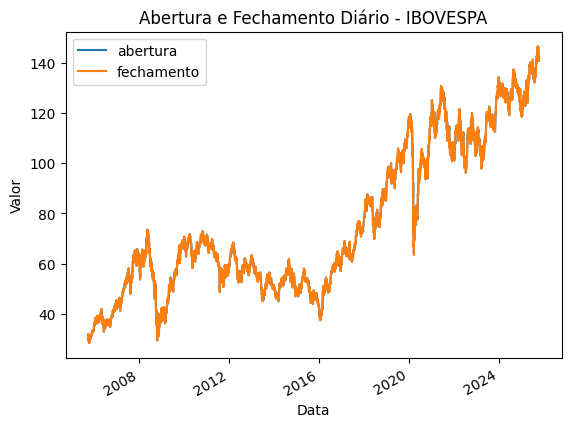

In [ ]:
# Visualização do valor de abertura E fechamento diário do IBOVESPA
df[['abertura', 'fechamento']].plot(kind='line')

plt.title("Abertura e Fechamento Diário - IBOVESPA")
plt.xlabel("Data")
plt.ylabel("Valor")

# Feature Engineering

In [ ]:
# Indicadores de data
df['ano'] = df.index.year
df['mes'] = df.index.month
df['dia'] = df.index.day
df['dia_da_semana'] = df.index.dayofweek

In [ ]:
# Indicadores de Média Móvel Simples (SMA)
df['sma_5d'] = df['fechamento'].rolling(window=5).mean()
df['sma_20d'] = df['fechamento'].rolling(window=20).mean()

In [ ]:
# Índice de Força Relativa (RSI) -- Relação entre as médias de ganhos e as médias de perda de um período
delta = df['fechamento'].diff(1)
ganho = (delta.where(delta > 0, 0)).rolling(window=14).mean()
perda = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = ganho / perda
df['rsi'] = 100 - (100 / (1 + rs))

In [ ]:
# Range do valor diário
df['range_diario'] = df['max'] - df['min']

## Features T-1

In [ ]:
df.columns

Index(['fechamento', 'abertura', 'max', 'min', 'volume', 'var', 'ano', 'mes',
       'dia', 'dia_da_semana', 'sma_5d', 'sma_20d', 'rsi', 'range_diario'],
      dtype='object')

In [ ]:
# Features usadas no dia anterior
features_shift = [
    'abertura',
    'max',
    'min',
    'volume',
    'sma_5d',
    'sma_20d',
    'rsi',
    'range_diario'
]

In [ ]:
# Versão shifted das features
for feature in features_shift:
    df[f'{feature}_t-1'] = df[feature].shift(1)

In [ ]:
# Removendo NaN
df.dropna(inplace=True)

In [ ]:
df.columns

Index(['fechamento', 'abertura', 'max', 'min', 'volume', 'var', 'ano', 'mes',
       'dia', 'dia_da_semana', 'sma_5d', 'sma_20d', 'rsi', 'range_diario',
       'abertura_t-1', 'max_t-1', 'min_t-1', 'volume_t-1', 'sma_5d_t-1',
       'sma_20d_t-1', 'rsi_t-1', 'range_diario_t-1'],
      dtype='object')

## Criação da Variável Alvo

In [ ]:
# Criação do target
df['alvo'] = (df['var'] > 0).astype(int)

In [ ]:
df.head(5)

,fechamento,abertura,max,min,volume,var,ano,mes,dia,dia_da_semana,...,range_diario,abertura_t-1,max_t-1,min_t-1,volume_t-1,sma_5d_t-1,sma_20d_t-1,rsi_t-1,range_diario_t-1,alvo
data,,,,,,,,,,,,,,,,,,,,,
2005-11-01,30.900,30.194,30.981,30.194,133760000.0,2.34,2005,11,1,1,...,0.787,29.333,30.252,29.333,103810000.0,29.5746,29.84400,49.462922,0.919,1
2005-11-03,31.100,30.898,31.487,30.898,118570000.0,0.65,2005,11,3,3,...,0.589,30.194,30.981,30.194,133760000.0,29.8550,29.79620,51.766304,0.787,1
2005-11-04,30.888,31.080,31.234,30.584,96990000.0,-0.68,2005,11,4,4,...,0.650,30.898,31.487,30.898,118570000.0,30.1290,29.78700,58.066649,0.589,0
2005-11-07,30.952,30.888,31.363,30.728,102680000.0,0.21,2005,11,7,0,...,0.635,31.080,31.234,30.584,96990000.0,30.4800,29.82320,57.293841,0.650,1
2005-11-08,30.971,30.951,31.078,30.587,75750000.0,0.06,2005,11,8,1,...,0.491,30.888,31.363,30.728,102680000.0,30.8068,29.90945,54.892503,0.635,1


# Preparação da Série

## Divisão Entre Treino e Teste

In [ ]:
train_size = len(df) - 22
df_train = df.iloc[:train_size]
df_test = df.iloc[train_size:]

In [ ]:
print(f"Formato do X_train: {df_train.shape}")
print(f"Formato do X_test: {df_test.shape}")

Formato do X_train: (4922, 23)
Formato do X_test: (22, 23)


In [ ]:
y_train = df_train['alvo']
y_test = df_test['alvo']

In [ ]:
# Remoção de colunas para evitar data leakage
remove_col = [
    'alvo',
    'var',
    'fechamento',
    'abertura',
    'max',
    'min',
    'volume'
]

In [ ]:
X_train = df_train.drop(columns=remove_col)
X_test = df_test.drop(columns=remove_col)

In [ ]:
X_train

,ano,mes,dia,dia_da_semana,sma_5d,sma_20d,rsi,range_diario,abertura_t-1,max_t-1,min_t-1,volume_t-1,sma_5d_t-1,sma_20d_t-1,rsi_t-1,range_diario_t-1
data,,,,,,,,,,,,,,,,
2005-11-01,2005,11,1,1,29.8550,29.79620,51.766304,0.787,29.333,30.252,29.333,1.038100e+08,29.5746,29.84400,49.462922,0.919
2005-11-03,2005,11,3,3,30.1290,29.78700,58.066649,0.589,30.194,30.981,30.194,1.337600e+08,29.8550,29.79620,51.766304,0.787
2005-11-04,2005,11,4,4,30.4800,29.82320,57.293841,0.650,30.898,31.487,30.898,1.185700e+08,30.1290,29.78700,58.066649,0.589
2005-11-07,2005,11,7,0,30.8068,29.90945,54.892503,0.635,31.080,31.234,30.584,9.699000e+07,30.4800,29.82320,57.293841,0.650
2005-11-08,2005,11,8,1,30.9622,29.95935,65.595804,0.491,30.888,31.363,30.728,1.026800e+08,30.8068,29.90945,54.892503,0.635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-09,2025,9,9,1,141.3814,138.71405,76.883217,0.681,142.640,143.089,141.329,7.440000e+09,141.1248,138.52885,78.329484,1.760
2025-09-10,2025,9,10,2,141.8784,138.99715,79.016733,1.570,141.794,142.286,141.605,7.480000e+09,141.3814,138.71405,76.883217,0.681
2025-09-11,2025,9,11,3,142.3100,139.33690,73.882591,1.664,141.612,143.182,141.612,7.140000e+09,141.8784,138.99715,79.016733,1.570


In [ ]:
print(f"Formato do X_train: {X_train.shape}")
print(f"Formato do X_test: {X_test.shape}")
print(f"Formato do y_train: {y_train.shape}")
print(f"Formato do y_test: {y_test.shape}")

Formato do X_train: (4922, 16)
Formato do X_test: (22, 16)
Formato do y_train: (4922,)
Formato do y_test: (22,)


In [ ]:
X_train.columns

Index(['ano', 'mes', 'dia', 'dia_da_semana', 'sma_5d', 'sma_20d', 'rsi',
       'range_diario', 'abertura_t-1', 'max_t-1', 'min_t-1', 'volume_t-1',
       'sma_5d_t-1', 'sma_20d_t-1', 'rsi_t-1', 'range_diario_t-1'],
      dtype='object')

# Pré-processamento dos Dados

In [ ]:
# Escalonamento dos Atributos (Normalização)
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Obter a última linha do DataFrame df
latest_data = df.tail(1).copy()
display(latest_data)

,fechamento,abertura,max,min,volume,var,ano,mes,dia,dia_da_semana,...,range_diario,abertura_t-1,max_t-1,min_t-1,volume_t-1,sma_5d_t-1,sma_20d_t-1,rsi_t-1,range_diario_t-1,alvo
data,,,,,,,,,,,,,,,,,,,,,
2025-10-15,142.604,141.683,142.905,141.154,1.032000e+10,0.65,2025,10,15,2,...,1.751,141.788,142.589,141.334,7.120000e+09,141.5998,144.2471,28.448508,1.255,1


# Modelos de Classificação

## Modelo 1 - Decision Tree

### Modelo Default - Decision Tree

In [ ]:
# Inicialização do modelo
model_dt = DecisionTreeClassifier(random_state=42)

In [ ]:
# Treinamento do modelo
model_dt.fit(X_train_scaled, y_train)

DecisionTreeClassifier(random_state=42)

In [ ]:
# Predições no conjunto de teste
y_pred_dt = model_dt.predict(X_test_scaled)

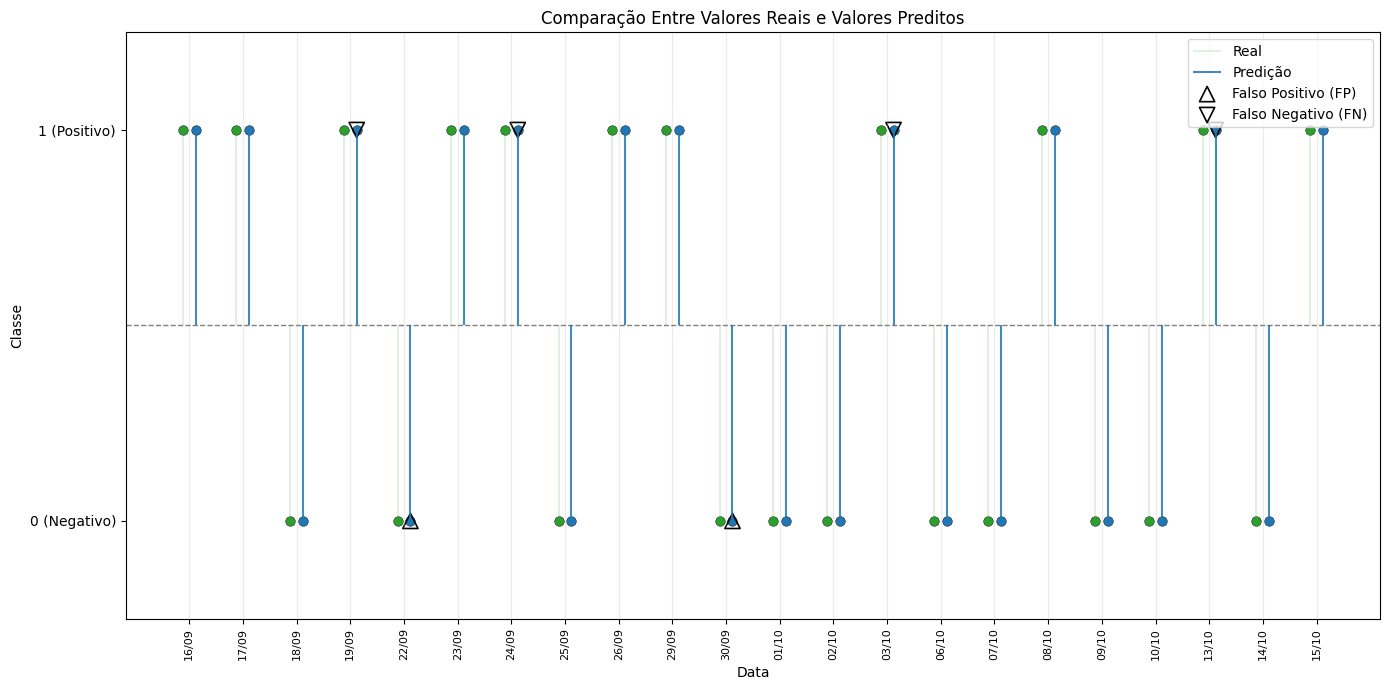


Métricas de Classificação
Accuracy:  0.7273
Precision: 0.7778
Recall:    0.6364
F1-score:  0.7000

Classification report:

              precision    recall  f1-score   support

           0     0.6923    0.8182    0.7500        11
           1     0.7778    0.6364    0.7000        11

    accuracy                         0.7273        22
   macro avg     0.7350    0.7273    0.7250        22
weighted avg     0.7350    0.7273    0.7250        22



In [ ]:
# Gera o gráfico de visualização das predições desse modelo
grafico_predicao(y_test, y_pred_dt, df_test)

### Otimização de Hiperparâmetros - Decision Tree

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, accuracy_score

# Definir o grid de hiperparâmetros para Decision Tree
param_grid_dt = {
    'max_depth': [None, 3, 5, 7, 10, 15, 20, 25],
    'min_samples_split': [2, 5, 10, 20, 30],
    'min_samples_leaf': [1, 2, 4, 8, 16],
    'criterion': ['gini', 'entropy']
}

# Métrica de desempenho = melhor acurácia
gs_metric = make_scorer(accuracy_score, greater_is_better=True)

# Inicializar o GridSearchCV com o modelo Decision Tree e o grid de parâmetros
grid_dt = GridSearchCV(DecisionTreeClassifier(random_state=42),
                       param_grid=param_grid_dt,
                       scoring=gs_metric,
                       cv=5,
                       n_jobs=1,
                       verbose=3)

# Realizar o grid search nos dados de treino escalonados
grid_dt.fit(X_train_scaled, y_train)

# Imprimir os melhores hiperparâmetros encontrados
best_params_dt = grid_dt.best_params_
print('Decision Tree - Melhores Hiperparâmetros:', best_params_dt)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits
[CV 1/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=0.615 total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=0.674 total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=0.699 total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=0.687 total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=0.648 total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5;, score=0.616 total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5;, score=0.680 total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5;, score=0.697 total time=

### Aplicação do Modelo com Novos Hiperparâmetros - Decision Tree

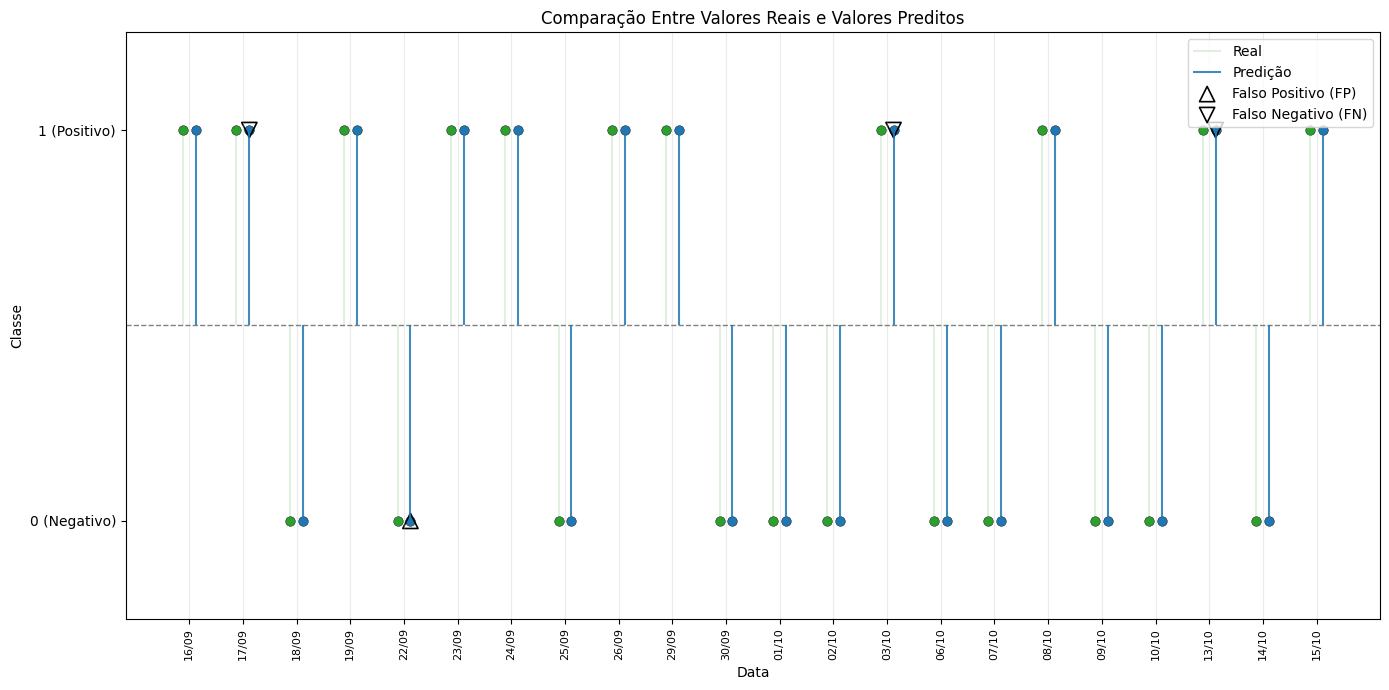


Métricas de Classificação
Accuracy:  0.8182
Precision: 0.8889
Recall:    0.7273
F1-score:  0.8000

Classification report:

              precision    recall  f1-score   support

           0     0.7692    0.9091    0.8333        11
           1     0.8889    0.7273    0.8000        11

    accuracy                         0.8182        22
   macro avg     0.8291    0.8182    0.8167        22
weighted avg     0.8291    0.8182    0.8167        22



In [ ]:
# Inicialização do modelo
model_dt = DecisionTreeClassifier(random_state=42, criterion = 'gini',
                                  max_depth = 7, min_samples_leaf = 8, min_samples_split = 2)
# Treinamento do modelo
model_dt.fit(X_train_scaled, y_train)

# Predições no conjunto de teste
y_pred_dt = model_dt.predict(X_test_scaled)

# Gera o gráfico de visualização das predições desse modelo
grafico_predicao(y_test, y_pred_dt, df_test)

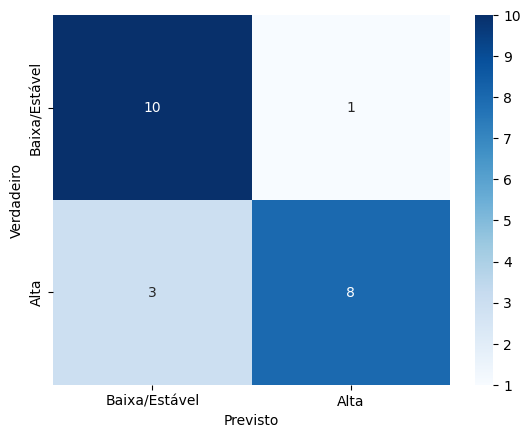

In [ ]:
# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred_dt)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Baixa/Estável', 'Alta'], yticklabels=['Baixa/Estável', 'Alta'])
plt.xlabel('Previsto')
plt.ylabel('Verdadeiro')
plt.show()

Importância das Features
             Feature  Importance
6                rsi    0.489378
14           rsi_t-1    0.410810
7       range_diario    0.046370
2                dia    0.014126
11        volume_t-1    0.010729
5            sma_20d    0.009209
15  range_diario_t-1    0.009057
3      dia_da_semana    0.006106
1                mes    0.003919
0                ano    0.000211
12        sma_5d_t-1    0.000085
4             sma_5d    0.000000
8       abertura_t-1    0.000000
9            max_t-1    0.000000
10           min_t-1    0.000000
13       sma_20d_t-1    0.000000


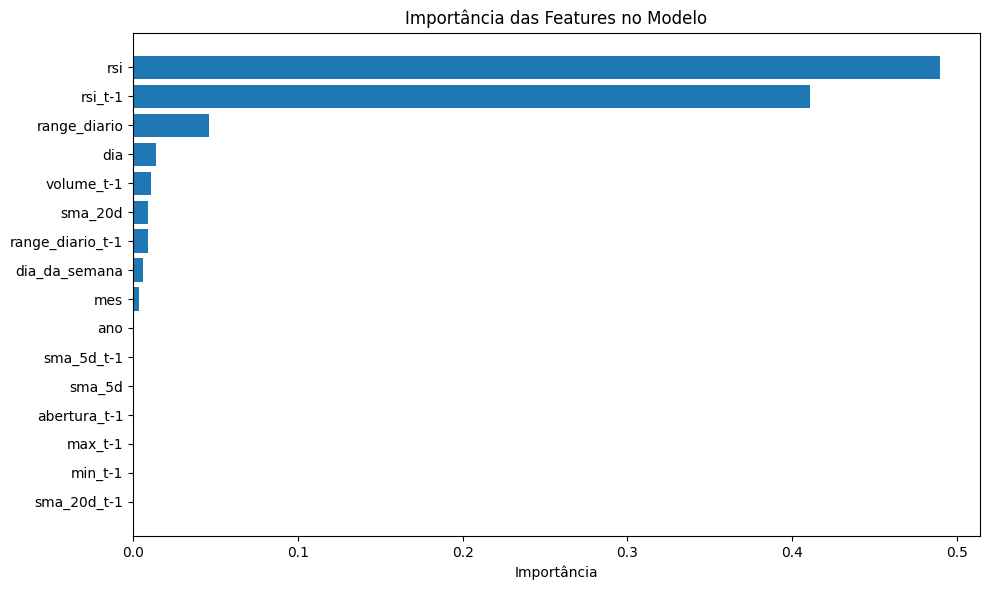

In [ ]:
# Importância dos atributos para este modelo
importancia_features(X_train, model_dt)

### Conclusão - Decision Tree

Comparamos dois modelos de Decision Tree: um com parâmetros padrão e outro otimizado via Grid Search.

**Modelo Default:**
* **Accuracy:** 0.7273
* **Precision (Classe 1 - Alta):** 0.7778
* **Recall (Classe 1 - Alta):** 0.6364
* **F1-score (Classe 1 - Alta):** 0.7000
* **Precision (Classe 0 - Baixa/Estável):** 0.6923
* **Recall (Classe 0 - Baixa/Estável):** 0.8182
* **F1-score (Classe 0 - Baixa/Estável):** 0.7500

**Modelo com Hiperparâmetros Tunados:**
* **Accuracy:** 0.8182
* **Precision (Classe 1 - Alta):** 0.8889
* **Recall (Classe 1 - Alta):** 0.7273
* **F1-score (Classe 1 - Alta):** 0.8000
* **Precision (Classe 0 - Baixa/Estável):** 0.7692
* **Recall (Classe 0 - Baixa/Estável):** 0.9091
* **F1-score (Classe 0 - Baixa/Estável):** 0.8333

**Análise e Conclusão:**

O modelo de Decision Tree com hiperparâmetros tunados demonstrou uma melhoria significativa em todas as métricas de desempenho em comparação com o modelo default. A acurácia geral aumentou de 0.7273 para 0.8182, superando a meta de 75% de acurácia, tornando-o apto para utilização.

Para a classe "Alta", o modelo tunado apresentou melhorias expressivas em Precisão, Recall e F1-score. Da mesma forma, para a classe "Baixa/Estável", o modelo tunado superou o modelo default em todas as métricas, com destaque para o aumento no Recall.

Considerando o objetivo de prever a tendência diária (alta ou baixa) com pelo menos 75% de acurácia, o modelo de Decision Tree com hiperparâmetros otimizados é claramente superior ao modelo default, oferecendo um desempenho mais robusto e equilibrado na identificação de ambas as tendências do mercado.

## Modelo 2 - Random Forest

### Modelo Default - Random Forest

In [ ]:
# Inicialização do modelo
model_rf = RandomForestClassifier(random_state=42)

In [ ]:
# Treinamento do modelo
model_rf.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Predições no conjunto de teste
y_pred_rf = model_rf.predict(X_test_scaled)

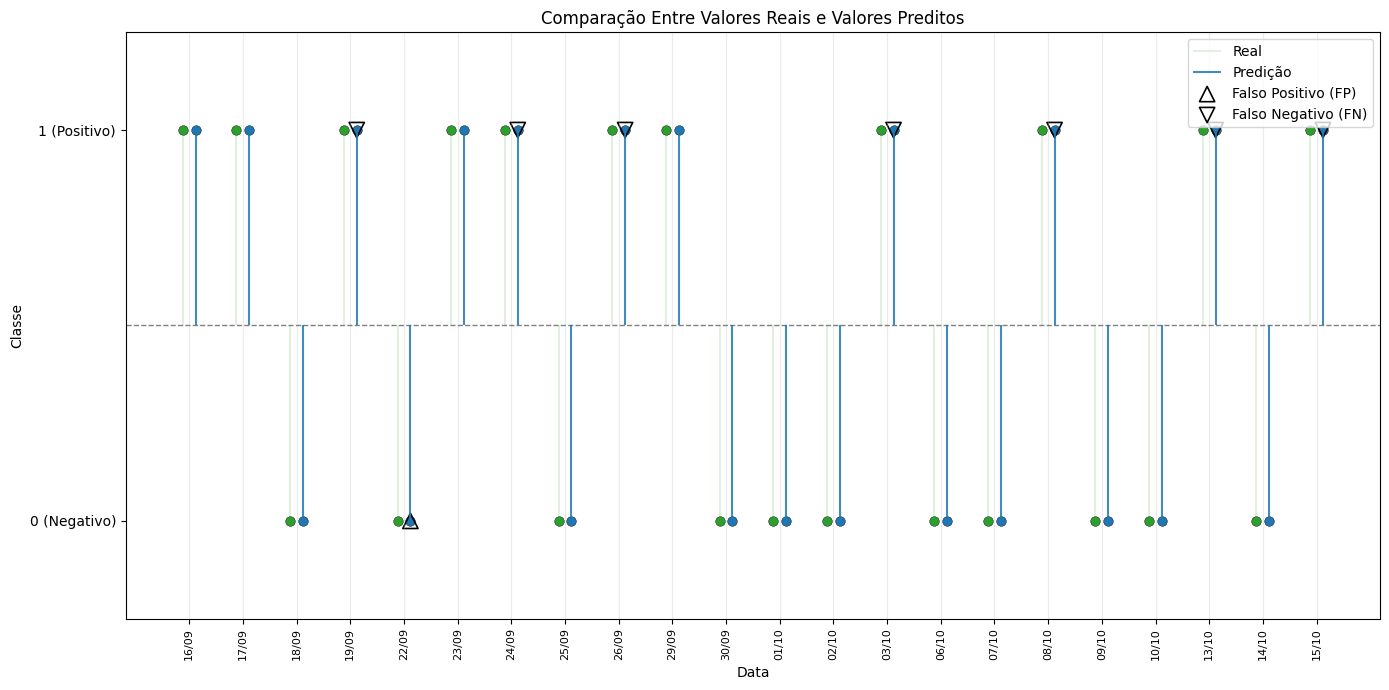


Métricas de Classificação
Accuracy:  0.6364
Precision: 0.8000
Recall:    0.3636
F1-score:  0.5000

Classification report:

              precision    recall  f1-score   support

           0     0.5882    0.9091    0.7143        11
           1     0.8000    0.3636    0.5000        11

    accuracy                         0.6364        22
   macro avg     0.6941    0.6364    0.6071        22
weighted avg     0.6941    0.6364    0.6071        22



In [ ]:
# Gera o gráfico de visualização das predições desse modelo
grafico_predicao(y_test, y_pred_rf, df_test)

### Otimização de Hiperparâmetros - Random Forest

In [ ]:
# Definir o grid de hiperparâmetros para Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Métrica de desempenho = melhor acurácia
gs_metric = make_scorer(accuracy_score, greater_is_better=True)

# Inicializar o GridSearchCV com o modelo Random Forest e o grid de parâmetros
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42),
                       param_grid=param_grid_rf,
                       scoring=gs_metric,
                       cv=5,
                       n_jobs=1,
                       verbose=3)

# Realizar o grid search nos dados de treino escalonados
grid_rf.fit(X_train_scaled, y_train)

# Imprimir os melhores hiperparâmetros encontrados
best_params_rf = grid_rf.best_params_
print('Random Forest - Melhores Hiperparâmetros:', best_params_rf)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV 1/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.529 total time=   2.3s
[CV 2/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.737 total time=   3.0s
[CV 3/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.716 total time=   2.2s
[CV 4/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.754 total time=   2.2s
[CV 5/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.708 total time=   2.2s
[CV 1/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.530 total time=   5.3s
[CV 2/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.740 tot

### Aplicação do Modelo com Novos Hiperparâmetros - Random Forest

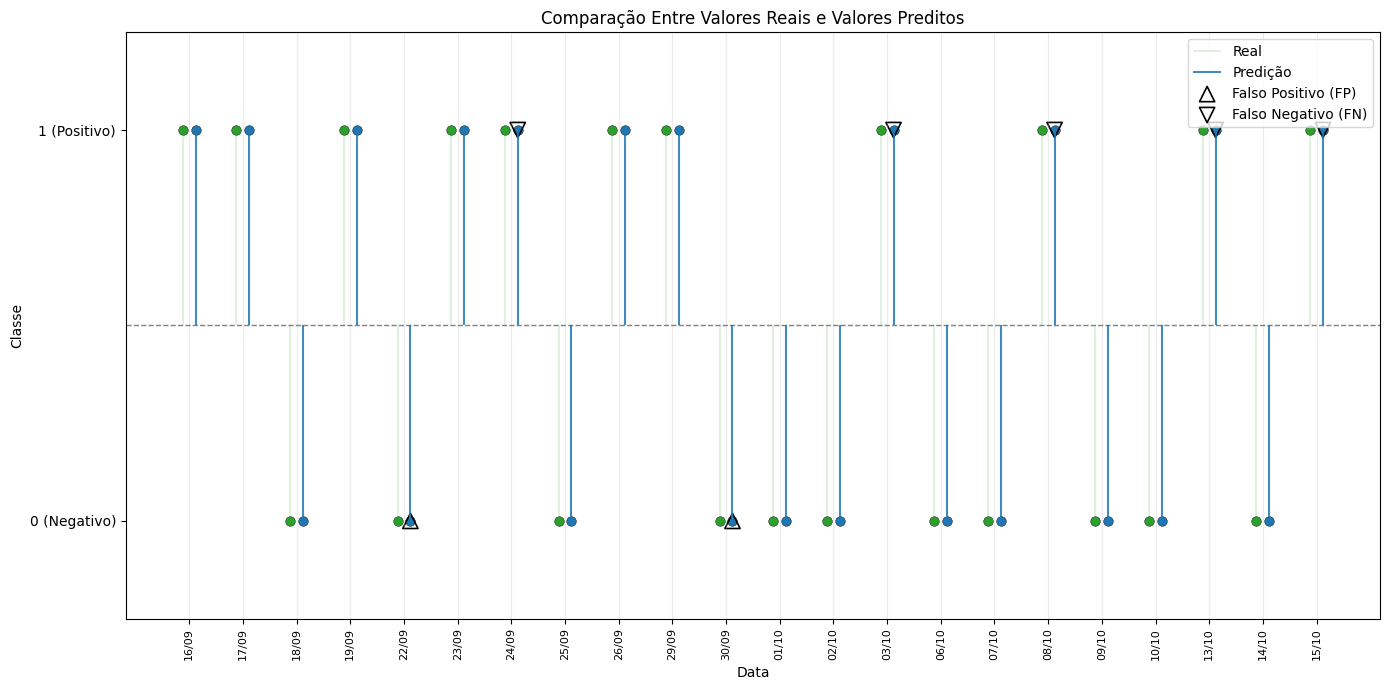


Métricas de Classificação
Accuracy:  0.6818
Precision: 0.7500
Recall:    0.5455
F1-score:  0.6316

Classification report:

              precision    recall  f1-score   support

           0     0.6429    0.8182    0.7200        11
           1     0.7500    0.5455    0.6316        11

    accuracy                         0.6818        22
   macro avg     0.6964    0.6818    0.6758        22
weighted avg     0.6964    0.6818    0.6758        22



In [ ]:
# Inicialização do modelo
model_rf = RandomForestClassifier(random_state=42, criterion = 'entropy', max_depth = None,
                                  min_samples_leaf = 2, min_samples_split = 5, n_estimators = 300)
# Treinamento do modelo
model_rf.fit(X_train_scaled, y_train)

# Predições no conjunto de teste
y_pred_rf = model_rf.predict(X_test_scaled)

# Gera o gráfico de visualização das predições desse modelo
grafico_predicao(y_test, y_pred_rf, df_test)

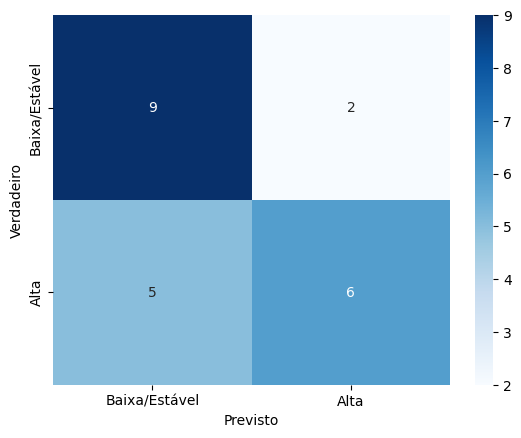

In [ ]:
# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Baixa/Estável', 'Alta'], yticklabels=['Baixa/Estável', 'Alta'])
plt.xlabel('Previsto')
plt.ylabel('Verdadeiro')
plt.show()

Importância das Features
             Feature  Importance
14           rsi_t-1    0.199211
6                rsi    0.189119
7       range_diario    0.074747
15  range_diario_t-1    0.069186
11        volume_t-1    0.060179
2                dia    0.050932
10           min_t-1    0.040922
9            max_t-1    0.040793
5            sma_20d    0.039851
13       sma_20d_t-1    0.039440
8       abertura_t-1    0.039144
12        sma_5d_t-1    0.038821
4             sma_5d    0.038655
1                mes    0.031063
3      dia_da_semana    0.026119
0                ano    0.021818


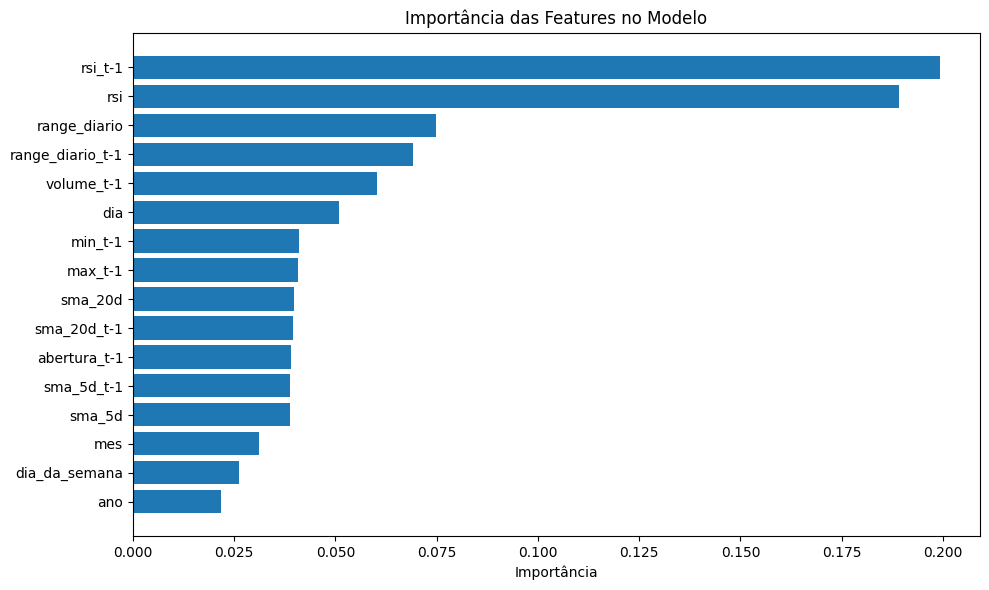

In [ ]:
# Importância dos atributos para este modelo
importancia_features(X_train, model_rf)

### Conclusão - Random Forest

Comparamos dois modelos de Random Forest: um com parâmetros padrão e outro otimizado via Grid Search.

**Modelo Default:**
* **Accuracy:** 0.6364
* **Precision (Classe 1 - Alta):** 0.8000
* **Recall (Classe 1 - Alta):** 0.3636
* **F1-score (Classe 1 - Alta):** 0.5000
* **Precision (Classe 0 - Baixa/Estável):** 0.5882
* **Recall (Classe 0 - Baixa/Estável):** 0.9091
* **F1-score (Classe 0 - Baixa/Estável):** 0.7143

**Modelo com Hiperparâmetros Tunados:**
* **Accuracy:** 0.6818
* **Precision (Classe 1 - Alta):** 0.7500
* **Recall (Classe 1 - Alta):** 0.5455
* **F1-score (Classe 1 - Alta):** 0.6316
* **Precision (Classe 0 - Baixa/Estável):** 0.6429
* **Recall (Classe 0 - Baixa/Estável):** 0.8182
* **F1-score (Classe 0 - Baixa/Estável):** 0.7200

**Análise e Conclusão:**

O modelo Random Forest com hiperparâmetros tunados apresentou uma acurácia ligeiramente superior (0.6818 vs 0.6364) e melhor desempenho na identificação de altas em comparação com o modelo default. No entanto, ambos os modelos de Random Forest não atingiram a meta de 75% de acurácia estabelecida. Portanto, apesar da otimização, o modelo Random Forest não é o mais adequado para este desafio.

## Modelo 3 - Regressão Logística

### Modelo Default - Regressão Logística

In [ ]:
# Inicialização do modelo
model_rl = LogisticRegression(random_state=42)

In [ ]:
# Treinamento do modelo
model_rl.fit(X_train_scaled, y_train)

LogisticRegression(random_state=42)

In [ ]:
# Predições no conjunto de teste
y_pred_rl = model_rl.predict(X_test_scaled)

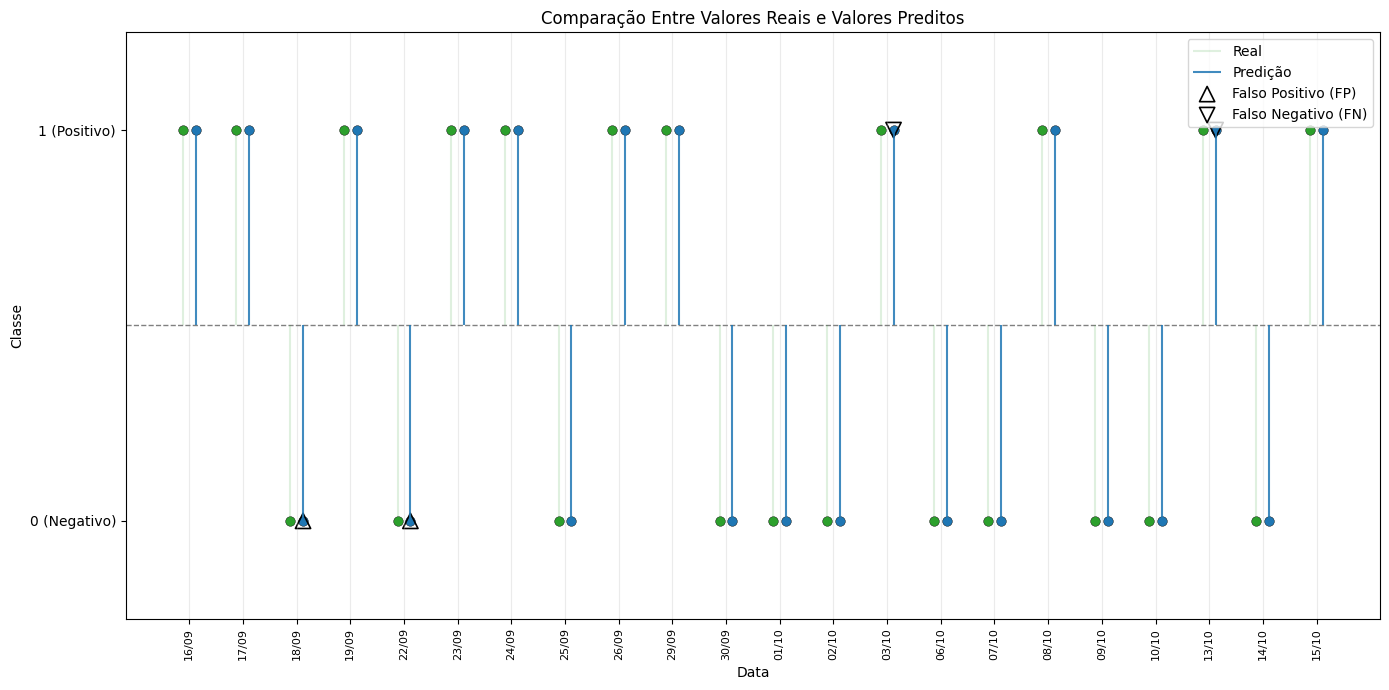


Métricas de Classificação
Accuracy:  0.8182
Precision: 0.8182
Recall:    0.8182
F1-score:  0.8182

Classification report:

              precision    recall  f1-score   support

           0     0.8182    0.8182    0.8182        11
           1     0.8182    0.8182    0.8182        11

    accuracy                         0.8182        22
   macro avg     0.8182    0.8182    0.8182        22
weighted avg     0.8182    0.8182    0.8182        22



In [ ]:
# Gera o gráfico de visualização das predições desse modelo
grafico_predicao(y_test, y_pred_rl, df_test)

### Otimização de Hiperparâmetros - Regressão Logística

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, accuracy_score, classification_report

param_grid_rl = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

# Métrica de desempenho
gs_metric = make_scorer(accuracy_score, greater_is_better=True)

# Inicializar o GridSearchCV com o modelo Regressão Logística e o grid de parâmetros
grid_rl = GridSearchCV(LogisticRegression(random_state=42),
                       param_grid=param_grid_rl,
                       scoring=gs_metric,
                       cv=5,
                       n_jobs=-1,
                       verbose=3)

# Realizar o grid search nos dados de treino escalonados
grid_rl.fit(X_train_scaled, y_train)

# Imprimir os melhores hiperparâmetros encontrados
best_params_rl = grid_rl.best_params_
print('Regressão Logística - Melhores Hiperparâmetros:', best_params_rl)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Regressão Logística - Melhores Hiperparâmetros: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


### Aplicação do Modelo com Novos Hiperparâmetros - Regressao Logistica

/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


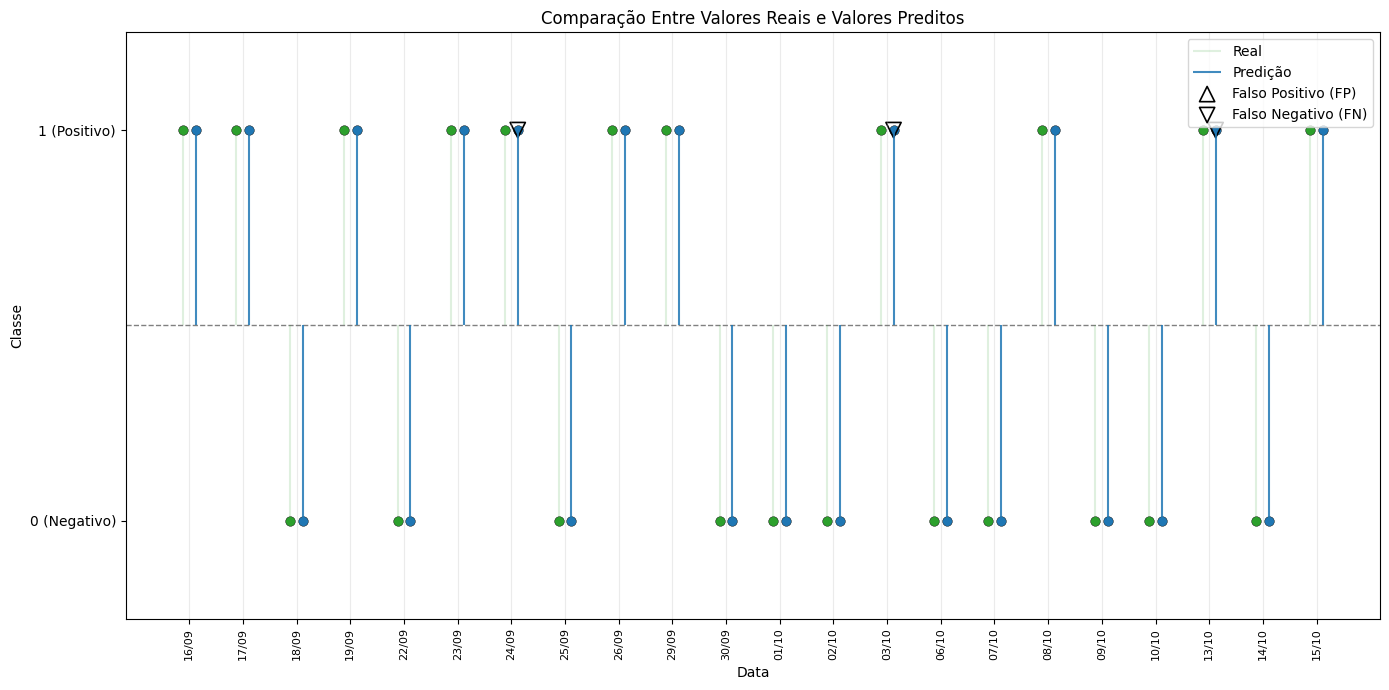


Métricas de Classificação
Accuracy:  0.8636
Precision: 1.0000
Recall:    0.7273
F1-score:  0.8421

Classification report:

              precision    recall  f1-score   support

           0     0.7857    1.0000    0.8800        11
           1     1.0000    0.7273    0.8421        11

    accuracy                         0.8636        22
   macro avg     0.8929    0.8636    0.8611        22
weighted avg     0.8929    0.8636    0.8611        22



In [ ]:
# Inicialização do modelo
model_rl = LogisticRegression(random_state=42, C = 100, penalty = 'l1', solver = 'liblinear')

# Treinamento do modelo
model_rl.fit(X_train_scaled, y_train)

# Predições no conjunto de teste
y_pred_rl = model_rl.predict(X_test_scaled)

# Gera o gráfico de visualização das predições desse modelo
grafico_predicao(y_test, y_pred_rl, df_test)

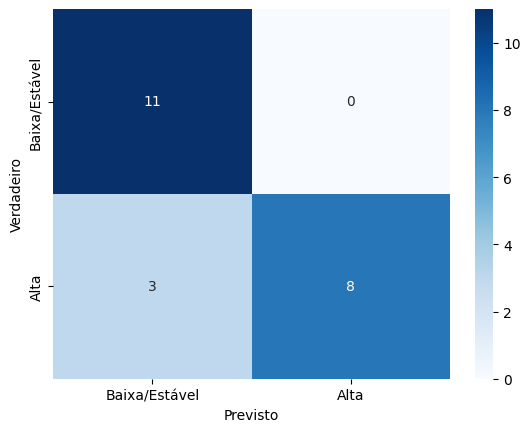

In [ ]:
# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred_rl)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Baixa/Estável', 'Alta'], yticklabels=['Baixa/Estável', 'Alta'])
plt.xlabel('Previsto')
plt.ylabel('Verdadeiro')
plt.show()

             Feature  Importance
4             sma_5d  210.194496
12        sma_5d_t-1  118.395825
5            sma_20d   68.889130
10           min_t-1   63.559824
9            max_t-1   62.261277
13       sma_20d_t-1   47.297701
6                rsi   23.900174
14           rsi_t-1   21.169841
8       abertura_t-1   11.709371
7       range_diario    3.196275
15  range_diario_t-1    2.033801
0                ano    0.198083
3      dia_da_semana    0.111291
11        volume_t-1    0.097059
2                dia    0.064267
1                mes    0.062536


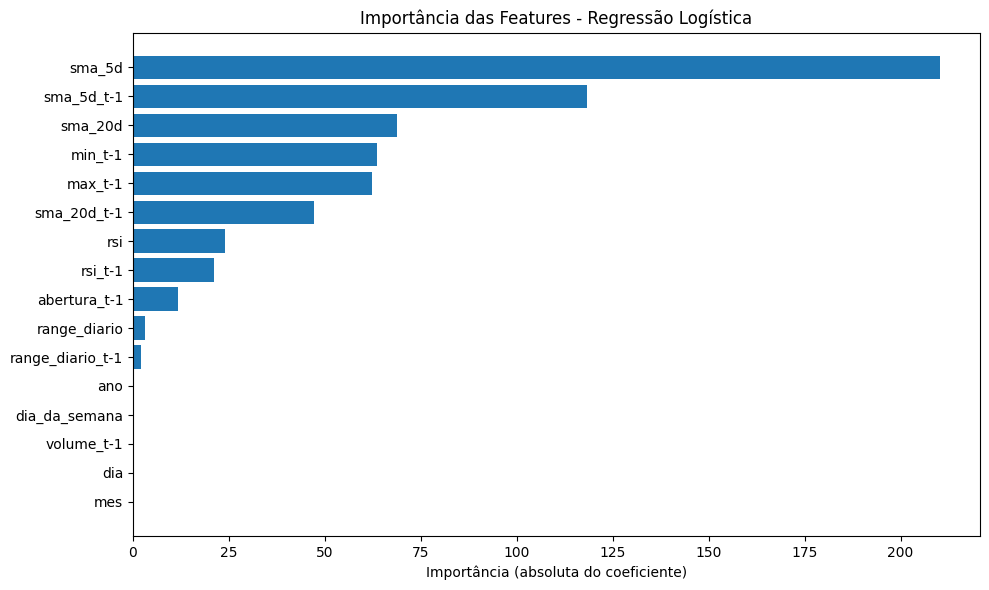

In [ ]:
# Importância das features com coeficientes
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': np.abs(model_rl.coef_[0])
}).sort_values('Importance', ascending=False)

print(feature_importance.to_string())

# Gráfico de importância das features
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importância (absoluta do coeficiente)')
plt.title('Importância das Features - Regressão Logística')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Conclusão - Regressão Logística

Comparamos dois modelos de Regressão Logística: um com parâmetros padrão e outro otimizado via Grid Search.

**Modelo Default:**
* **Accuracy:** 0.8182
* **Precision (Classe 1 - Alta):** 0.8182
* **Recall (Classe 1 - Alta):** 0.8182
* **F1-score (Classe 1 - Alta):** 0.8182
* **Precision (Classe 0 - Baixa/Estável):** 0.8182
* **Recall (Classe 0 - Baixa/Estável):** 0.8182
* **F1-score (Classe 0 - Baixa/Estável):** 0.8182

**Modelo com Hiperparâmetros Tunados:**
* **Accuracy:** 0.8636
* **Precision (Classe 1 - Alta):** 1.0000
* **Recall (Classe 1 - Alta):** 0.7273
* **F1-score (Classe 1 - Alta):** 0.8421
* **Precision (Classe 0 - Baixa/Estável):** 0.7857
* **Recall (Classe 0 - Baixa/Estável):** 1.0000
* **F1-score (Classe 0 - Baixa/Estável):** 0.8800

**Análise e Conclusão:**

O modelo de Regressão Logística com hiperparâmetros tunados demonstrou uma melhoria notável na acurácia geral (0.8636 vs 0.8182) em comparação com o modelo default. A otimização via Grid Search resultou em um modelo com desempenho superior para ambas as classes, superando a meta de 75% de acurácia e tornando-o apto a ser utilizado.

Para a classe "Alta", o modelo tunado alcançou uma Precisão perfeita (1.0000), significando que quando prevê uma alta, ele está sempre correto no conjunto de teste - embora o cenário provavelmente não fosse esse com um conjunto de testes maior. Embora o Recall para a classe "Alta" tenha diminuído ligeiramente (0.7273 vs 0.8182), o F1-score aumentou (0.8421 vs 0.8182), indicando um bom equilíbrio entre Precisão e Recall para esta classe e uma melhor performance geral na identificação de altas.

Para a classe "Baixa/Estável", o modelo tunado apresentou um aumento significativo no Recall (1.0000 vs 0.8182) e no F1-score (0.8800 vs 0.8182), com a Precisão se mantendo robusta (0.7857 vs 0.8182). Isso mostra que o modelo otimizado é muito eficaz em identificar corretamente os dias de baixa/estabilidade, praticamente sem falsos positivos (prever baixa quando na verdade é alta) no conjunto de teste.

Considerando o objetivo de prever a tendência diária (alta ou baixa) com pelo menos 75% de acurácia, o modelo de Regressão Logística com hiperparâmetros otimizados é um dos modelos que melhor atende a este critério, superando o modelo default em acurácia geral e apresentando um desempenho robusto e equilibrado para ambas as classes.

## Modelo 4 - XGBoost

### Modelo Default - XGBoost

In [ ]:
# Inicialização do modelo
model_xgb = xgb.XGBClassifier()

In [ ]:
# Treinamento do modelo
model_xgb.fit(X_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
# Predições no conjunto de teste
y_pred_xgb = model_xgb.predict(X_test_scaled)

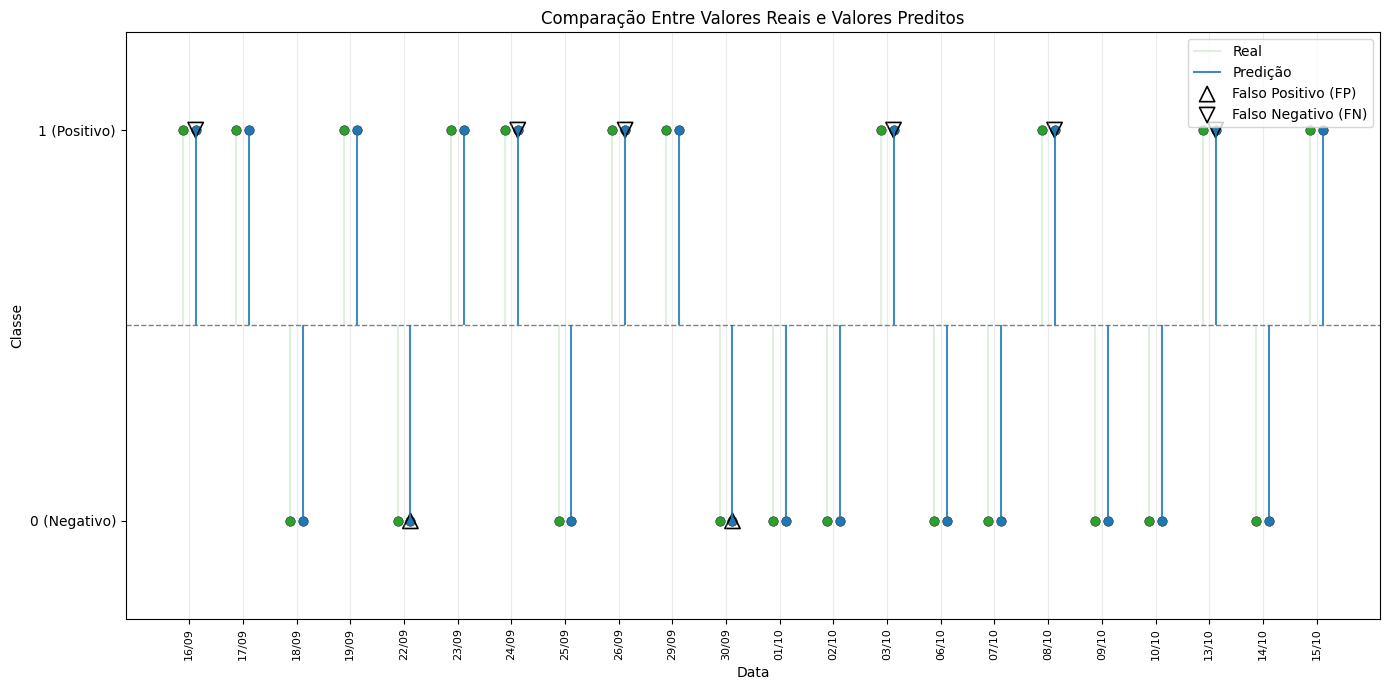


Métricas de Classificação
Accuracy:  0.6364
Precision: 0.7143
Recall:    0.4545
F1-score:  0.5556

Classification report:

              precision    recall  f1-score   support

           0     0.6000    0.8182    0.6923        11
           1     0.7143    0.4545    0.5556        11

    accuracy                         0.6364        22
   macro avg     0.6571    0.6364    0.6239        22
weighted avg     0.6571    0.6364    0.6239        22



In [ ]:
# Gera o gráfico de visualização das predições desse modelo
grafico_predicao(y_test, y_pred_xgb, df_test)

### Otimização de Parâmetros - XGBoost

In [ ]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.metrics import make_scorer, accuracy_score, classification_report

# Definir o grid de hiperparâmetros para XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Métrica de desempenho = melhor acurácia
gs_metric = make_scorer(accuracy_score, greater_is_better=True)

# Inicializar o GridSearchCV com o modelo XGBoost e o grid de parâmetros
grid_xgb = GridSearchCV(xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
                       param_grid=param_grid_xgb,
                       scoring=gs_metric,
                       cv=5,
                       n_jobs=-1,
                       verbose=3)

# Realizar o grid search nos dados de treino escalonados
grid_xgb.fit(X_train_scaled, y_train)

# Imprimir os melhores hiperparâmetros encontrados
best_params_xgb = grid_xgb.best_params_
print('XGBoost - Melhores Hiperparâmetros:', best_params_xgb)

# Treinar o modelo final com os melhores hiperparâmetros
model_xgb_tuned = xgb.XGBClassifier(**best_params_xgb, random_state=42, use_label_encoder=False, eval_metric='logloss')
model_xgb_tuned.fit(X_train_scaled, y_train)

# Avaliar o modelo otimizado no conjunto de teste
y_pred_xgb_tuned = model_xgb_tuned.predict(X_test_scaled)

print("\nMétricas do Modelo XGBoost Otimizado:")
print(classification_report(y_test, y_pred_xgb_tuned, digits=4, zero_division=0))

Fitting 5 folds for each of 972 candidates, totalling 4860 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:24:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost - Melhores Hiperparâmetros: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}

Métricas do Modelo XGBoost Otimizado:
              precision    recall  f1-score   support

           0     0.8000    0.7273    0.7619        11
           1     0.7500    0.8182    0.7826        11

    accuracy                         0.7727        22
   macro avg     0.7750    0.7727    0.7723        22
weighted avg     0.7750    0.7727    0.7723        22



### Aplicação do Modelo com Novos Hiperparâmetros - XGBoost

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:24:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


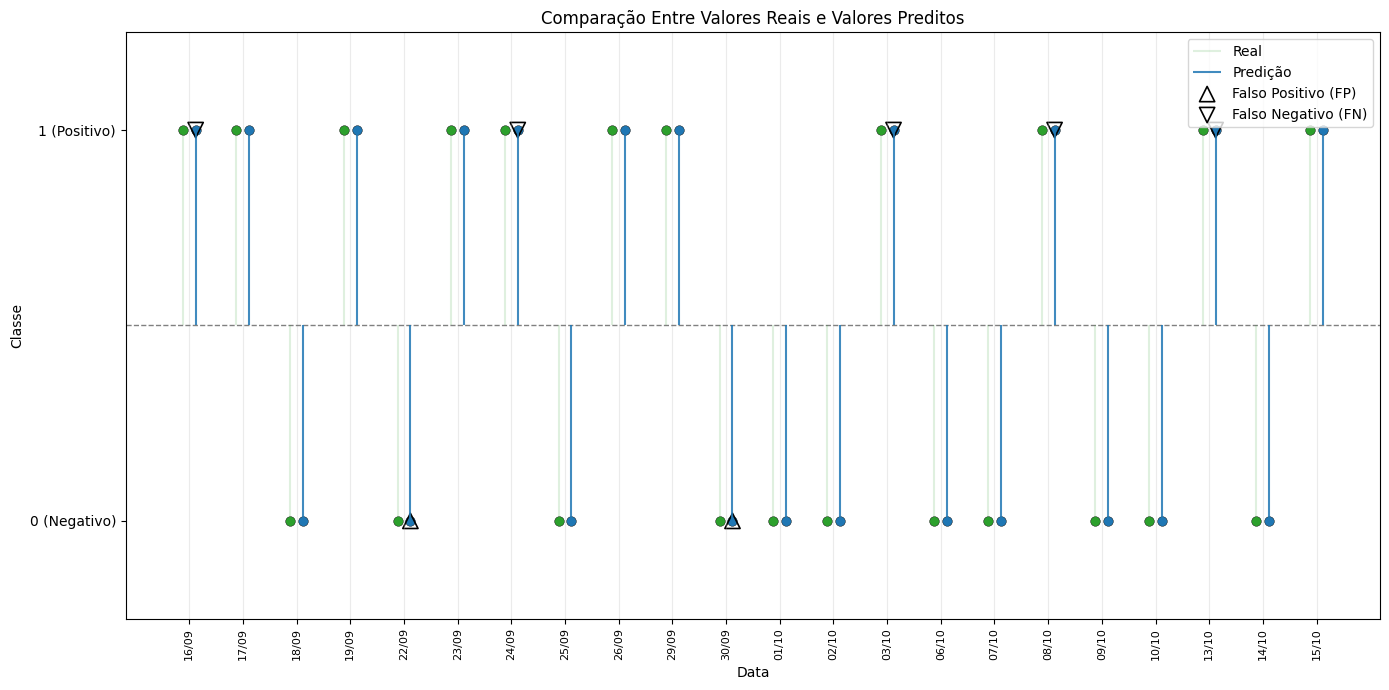


Métricas de Classificação
Accuracy:  0.6818
Precision: 0.7500
Recall:    0.5455
F1-score:  0.6316

Classification report:

              precision    recall  f1-score   support

           0     0.6429    0.8182    0.7200        11
           1     0.7500    0.5455    0.6316        11

    accuracy                         0.6818        22
   macro avg     0.6964    0.6818    0.6758        22
weighted avg     0.6964    0.6818    0.6758        22



In [ ]:
# Inicialização do modelo
model_xgb = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.4,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
# Treinamento do modelo
model_xgb.fit(X_train_scaled, y_train)
# Predições no conjunto de teste
y_pred_xgb = model_xgb.predict(X_test_scaled)
# Gera o gráfico de visualização das predições desse modelo
grafico_predicao(y_test, y_pred_xgb, df_test)

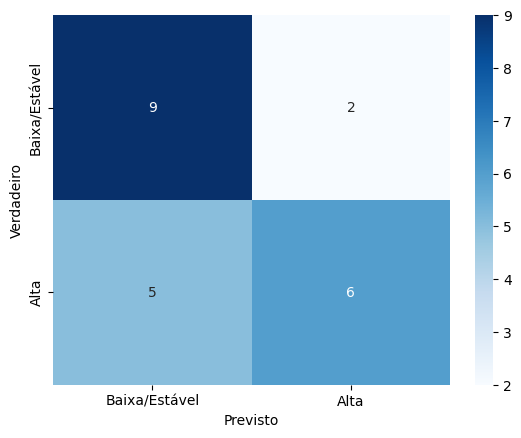

In [ ]:
# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Baixa/Estável', 'Alta'], yticklabels=['Baixa/Estável', 'Alta'])
plt.xlabel('Previsto')
plt.ylabel('Verdadeiro')
plt.show()

Importância das Features
             Feature  Importance
14           rsi_t-1    0.159733
6                rsi    0.152690
7       range_diario    0.061093
10           min_t-1    0.051211
11        volume_t-1    0.050763
13       sma_20d_t-1    0.050620
9            max_t-1    0.049817
4             sma_5d    0.049716
15  range_diario_t-1    0.049334
0                ano    0.049049
8       abertura_t-1    0.048344
2                dia    0.046276
5            sma_20d    0.046275
1                mes    0.045906
12        sma_5d_t-1    0.044745
3      dia_da_semana    0.044429


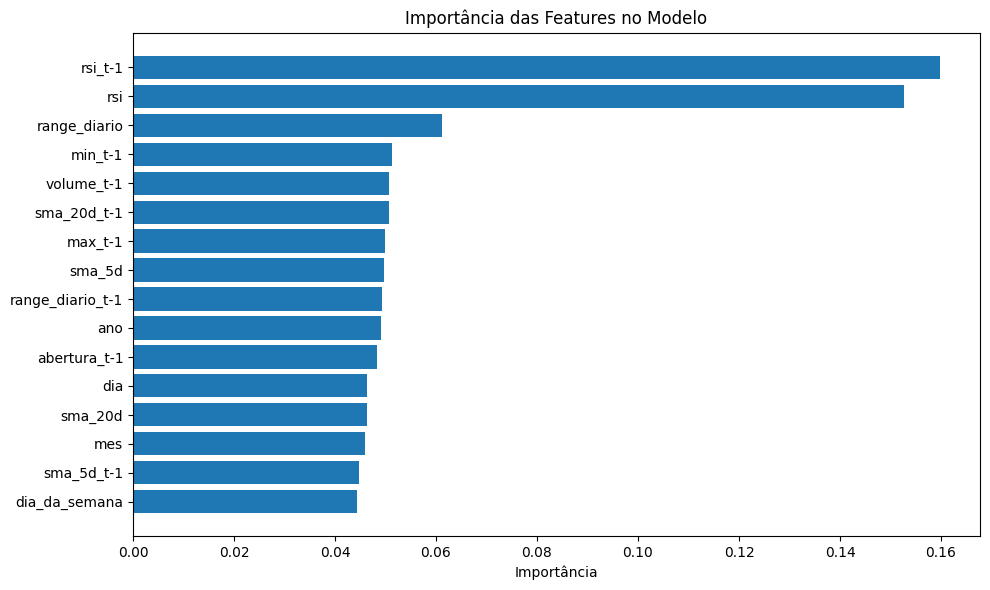

In [ ]:
# Plota a importância dos atributos para este modelo
importancia_features(X_train, model_xgb)

### Conclusão - XGBoost

Comparamos dois modelos de XGBoost: um com parâmetros padrão e outro otimizado via Grid Search.

**Modelo Default:**
* **Accuracy:** 0.6364
* **Precision (Classe 1 - Alta):** 0.7143
* **Recall (Classe 1 - Alta):** 0.4545
* **F1-score (Classe 1 - Alta):** 0.5556
* **Precision (Classe 0 - Baixa/Estável):** 0.6000
* **Recall (Classe 0 - Baixa/Estável):** 0.8182
* **F1-score (Classe 0 - Baixa/Estável):** 0.6923

**Modelo com Hiperparâmetros Tunados:**
* **Accuracy:** 0.6818
* **Precision (Classe 1 - Alta):** 0.7500
* **Recall (Classe 1 - Alta):** 0.5455
* **F1-score (Classe 1 - Alta):** 0.6316
* **Precision (Classe 0 - Baixa/Estável):** 0.6429
* **Recall (Classe 0 - Baixa/Estável):** 0.8182
* **F1-score (Classe 0 - Baixa/Estável):** 0.7200

**Análise e Conclusão:**

O modelo XGBoost com hiperparâmetros tunados apresentou uma ligeira melhoria na acurácia geral (0.6818 vs 0.6364) e no Recall para a classe "Alta" (0.5455 vs 0.4545) em comparação com o modelo default. No entanto, apesar da otimização, ambos os modelos de XGBoost ficaram abaixo da meta de 75% de acurácia. Portanto, o modelo XGBoost, com as configurações testadas, não é considerado apto para este desafio.

## Modelo 5 - SVM -- Escolhido para a realização do forecast

### Modelo Default - SVM

In [ ]:
svm = Pipeline([('linear_svc', LinearSVC(C=1))])

In [ ]:
svm.fit(X_train_scaled, y_train)
svm_pred = svm.predict(X_test_scaled)

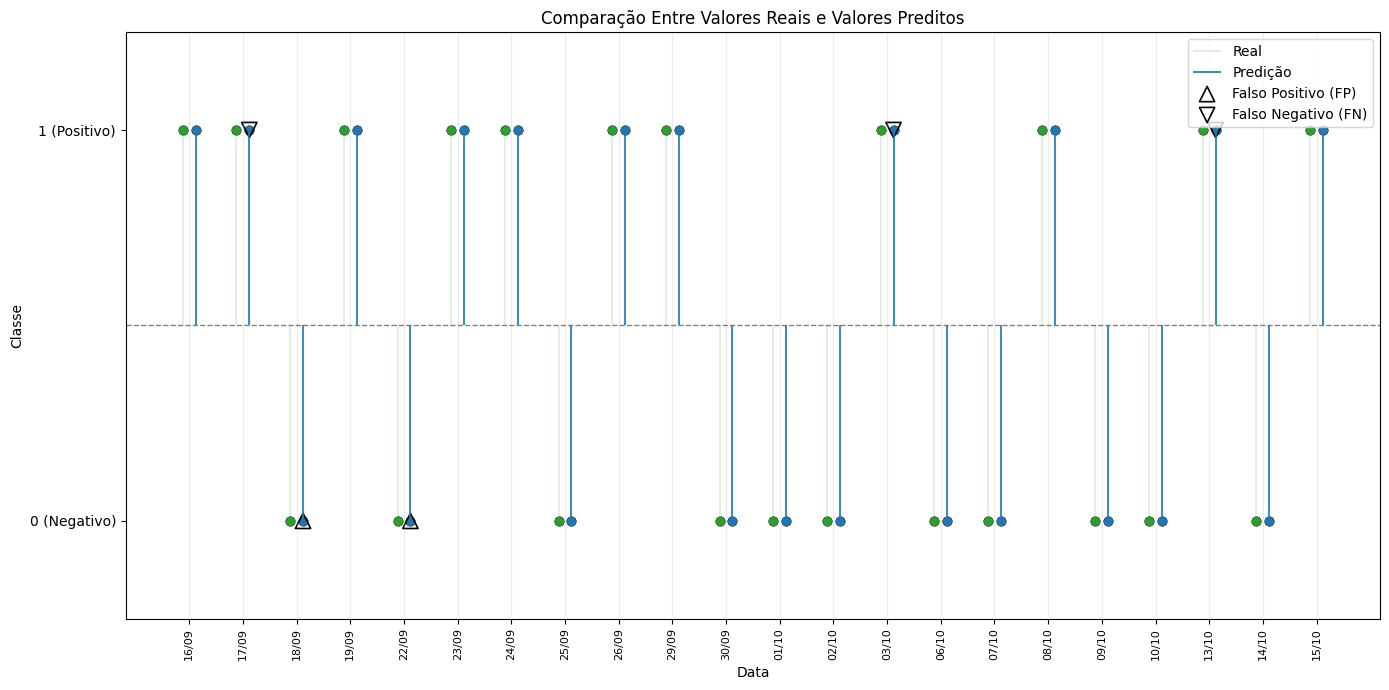


Métricas de Classificação
Accuracy:  0.7727
Precision: 0.8000
Recall:    0.7273
F1-score:  0.7619

Classification report:

              precision    recall  f1-score   support

           0     0.7500    0.8182    0.7826        11
           1     0.8000    0.7273    0.7619        11

    accuracy                         0.7727        22
   macro avg     0.7750    0.7727    0.7723        22
weighted avg     0.7750    0.7727    0.7723        22



In [ ]:
# Gera o gráfico de visualização das predições desse modelo
grafico_predicao(y_test, svm_pred, df_test)

### Otimização de Hiperparâmetros - SVM

In [ ]:
# Definir o pipeline com o scaler e o modelo SVM
pipeline_svm = Pipeline([
    ('scaler', MinMaxScaler()),
    ('svm', SVC(random_state=42))
])

# Definir o grid de hiperparâmetros para o modelo SVM dentro da pipeline
param_grid_svm = {
    'svm__C': [0.1, 1, 10, 100],
    'svm__gamma': ['scale', 'auto'],
    'svm__kernel': ['linear', 'rbf', 'poly'],
    'svm__degree': [2, 3, 4]
}

# Métrica de desempenho = melhor acurácia
gs_metric = make_scorer(accuracy_score, greater_is_better=True)

# Inicializar o GridSearchCV com o pipeline e o grid de parâmetros
grid_svm = GridSearchCV(pipeline_svm,
                        param_grid=param_grid_svm,
                        scoring=gs_metric,
                        cv=5,
                        n_jobs=-1,
                        verbose=3)

# Realizar o grid search nos dados de treino
grid_svm.fit(X_train, y_train)

# Imprimir os melhores hiperparâmetros encontrados
best_params_svm = grid_svm.best_params_
print('SVM - Melhores Hiperparâmetros:', best_params_svm)

# Avaliar o modelo otimizado no conjunto de teste
y_pred_svm_tuned = grid_svm.predict(X_test)

print("\nMétricas do Modelo SVM Otimizado:")
print(classification_report(y_test, y_pred_svm_tuned, digits=4, zero_division=0))

Fitting 5 folds for each of 72 candidates, totalling 360 fits
SVM - Melhores Hiperparâmetros: {'svm__C': 100, 'svm__degree': 2, 'svm__gamma': 'scale', 'svm__kernel': 'poly'}

Métricas do Modelo SVM Otimizado:
              precision    recall  f1-score   support

           0     0.8462    1.0000    0.9167        11
           1     1.0000    0.8182    0.9000        11

    accuracy                         0.9091        22
   macro avg     0.9231    0.9091    0.9083        22
weighted avg     0.9231    0.9091    0.9083        22



### Aplicação do Modelo com Novos Hiperparâmetros - SVM

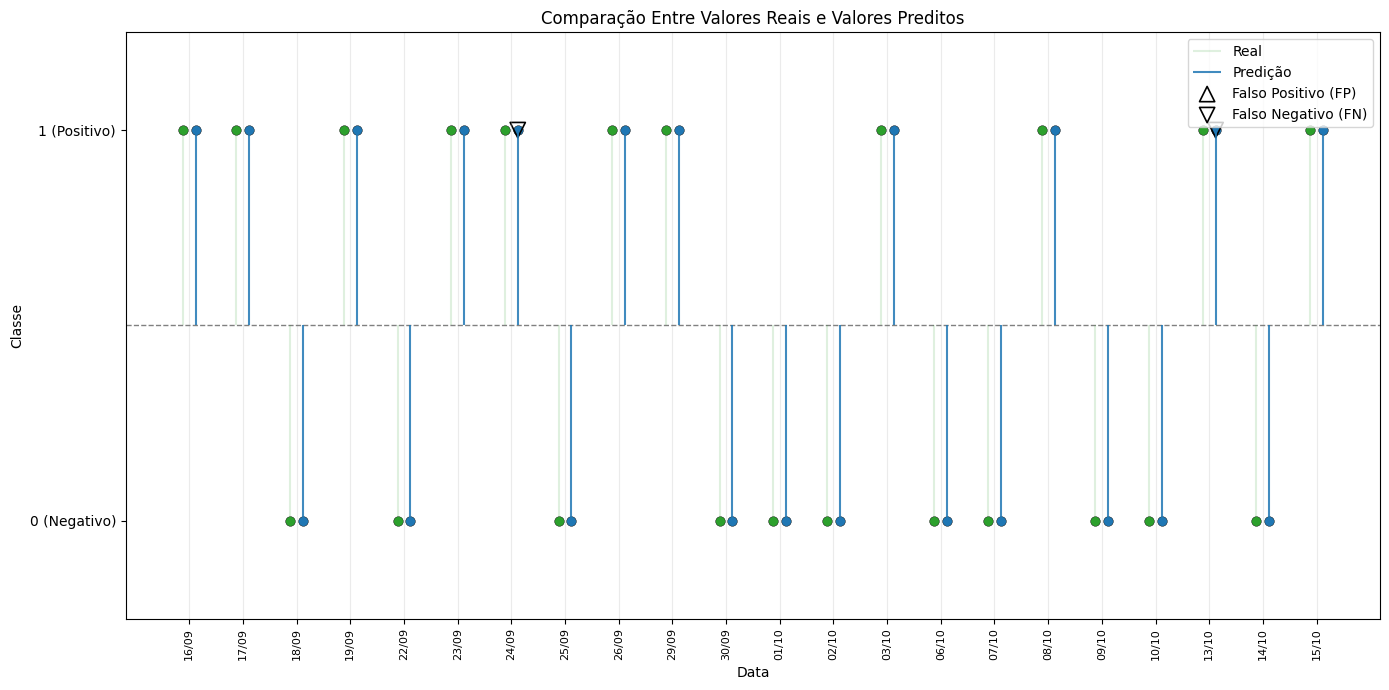


Métricas de Classificação
Accuracy:  0.9091
Precision: 1.0000
Recall:    0.8182
F1-score:  0.9000

Classification report:

              precision    recall  f1-score   support

           0     0.8462    1.0000    0.9167        11
           1     1.0000    0.8182    0.9000        11

    accuracy                         0.9091        22
   macro avg     0.9231    0.9091    0.9083        22
weighted avg     0.9231    0.9091    0.9083        22



In [ ]:
# Inicialização do modelo SVM com os melhores hiperparâmetros encontrados
# Usando SVC com kernel polinomial, C=100, degree=2 e gamma='scale' (padrão)
svm = Pipeline([('svm', SVC(C=100, degree=2, gamma='scale', kernel='poly', random_state=42))])

# Treinamento do modelo
svm.fit(X_train_scaled, y_train)

# Predições no conjunto de teste
svm_pred = svm.predict(X_test_scaled)

# Gera o gráfico de visualização das predições desse modelo
grafico_predicao(y_test, svm_pred, df_test)

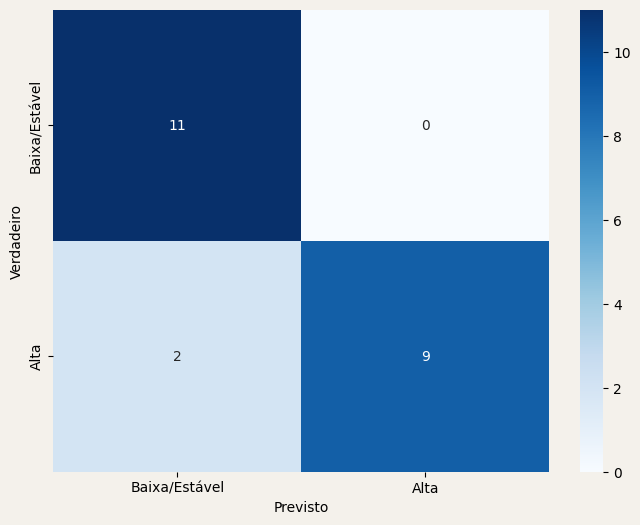

In [ ]:
# Matriz de Confusão
cm = confusion_matrix(y_test, svm_pred)

plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                 xticklabels=['Baixa/Estável', 'Alta'],
                 yticklabels=['Baixa/Estável', 'Alta'])

fig = ax.get_figure()
fig.set_facecolor('#f4f1eb')
ax.set_facecolor('#f4f1eb')
plt.xlabel('Previsto')
plt.ylabel('Verdadeiro')

plt.show()

### Conclusão - SVM

Comparamos dois modelos de SVM: um modelo linear padrão (`LinearSVC`) e um modelo `SVC` otimizado via Grid Search.

**Modelo Default (LinearSVC):**
* **Accuracy:** 0.7727
* **Precision (Classe 1 - Alta):** 0.8000
* **Recall (Classe 1 - Alta):** 0.7273
* **F1-score (Classe 1 - Alta):** 0.7619
* **Precision (Classe 0 - Baixa/Estável):** 0.7500
* **Recall (Classe 0 - Baixa/Estável):** 0.8182
* **F1-score (Classe 0 - Baixa/Estável):** 0.7826

**Modelo com Hiperparâmetros Tunados (SVC com kernel 'poly'):**
* **Accuracy:** 0.9091
* **Precision (Classe 1 - Alta):** 1.0000
* **Recall (Classe 1 - Alta):** 0.8182
* **F1-score (Classe 1 - Alta):** 0.9000
* **Precision (Classe 0 - Baixa/Estável):** 0.8462
* **Recall (Classe 0 - Baixa/Estável):** 1.0000
* **F1-score (Classe 0 - Baixa/Estável):** 0.9167

**Análise e Conclusão:**

O modelo SVM otimizado com kernel polinomial demonstrou uma melhoria substancial em todas as métricas de desempenho em comparação com o modelo LinearSVC padrão. A acurácia geral aumentou significativamente de 0.7727 para 0.9091, superando o requisito mínimo de 75% de acurácia, tornando-o apto para a utilização.

Para a classe "Alta", o modelo tunado alcançou uma Precisão perfeita (1.0000), o que não ocorreria caso o grupo de teste fosse maior, porém indica que ele é muito confiável ao prever um dia de alta. O Recall (0.8182) também é bom, garantindo que uma alta proporção de dias de alta reais seja identificada.

Para a classe "Baixa/Estável", o modelo tunado também apresentou melhorias notáveis, com alta Precisão (0.8462) e um Recall muito alto (1.0000),  o que não ocorreria caso o grupo de teste fosse maior, porém significa que ele é muito eficaz em identificar dias de baixa/estabilidade e minimiza falsos positivos (prever alta quando na verdade é baixa/estável).

Considerando o objetivo do Tech Challenge de atingir pelo menos 75% de acurácia na previsão da tendência diária do IBOVESPA, o modelo SVM com hiperparâmetros tunados e kernel polinomial é o que apresentou o melhor desempenho entre todos os modelos testados, com uma acurácia de 0.9091 e um desempenho robusto e equilibrado para ambas as classes. Este modelo é o mais promissor para a solução final.

# Modelos Time Series

## Visualização da Série Temporal

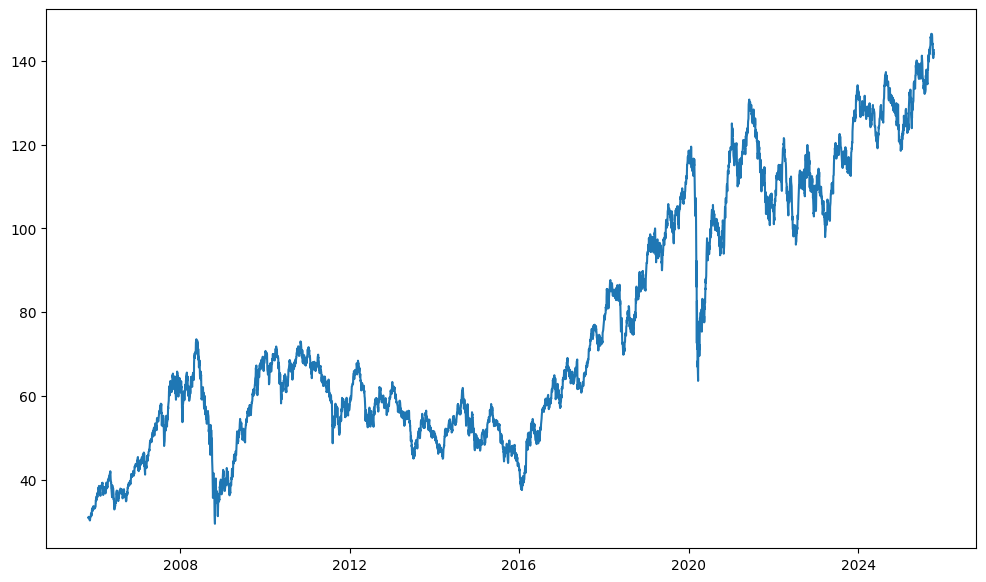

In [ ]:
# Visualização da série temporal
plt.figure(figsize=(12,7))
plt.plot(df.index, df['fechamento'])

## Decomposição da Série Temporal


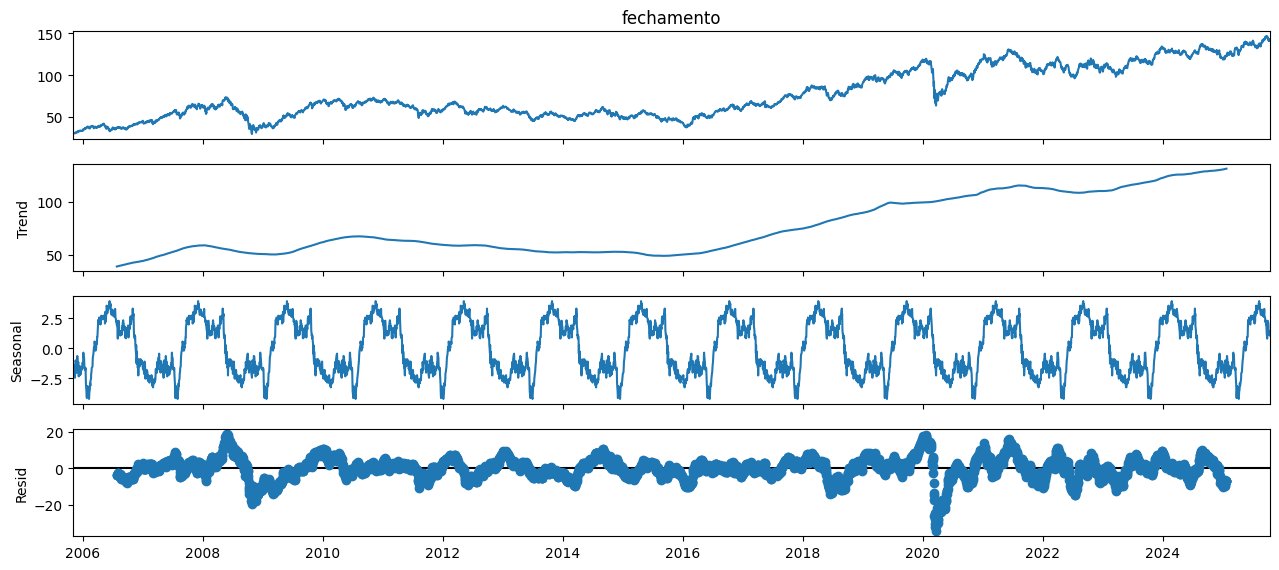

In [ ]:
result = seasonal_decompose(df['fechamento'], model='additive', period=365)
fig = result.plot()
fig.set_size_inches(14,6)

## Autocorrelação da Série Temporal (ACF)

In [ ]:
def plot_acf(df, lags=730, title="Autocorrelação da Série Temporal"):

    fig, ax = plt.subplots(figsize=(15, 5))

    _plot_acf(df, lags=lags, ax=ax, alpha=0.05)
    ax.set_title(title)
    ax.set_xlabel("Lags")
    ax.set_ylabel("Autocorrelação")
    fig.set_tight_layout(True)

    acf_x = sm.tsa.acf(df, alpha=0.05, nlags=lags)
    acf, ci = acf_x[:2]
    intercept_point = np.where(abs(acf) < (ci[:, 1] - acf))
    if intercept_point[0].size > 0:
        print(
            f"Os coeficientes da função de autocorrelação (ACF) cruzam o limite de significância no lag {intercept_point[0][0]}"
        )
    else:
        print("Os coeficientes da ACF não cruzam o limite de significância")

Os coeficientes da função de autocorrelação (ACF) cruzam o limite de significância no lag 423


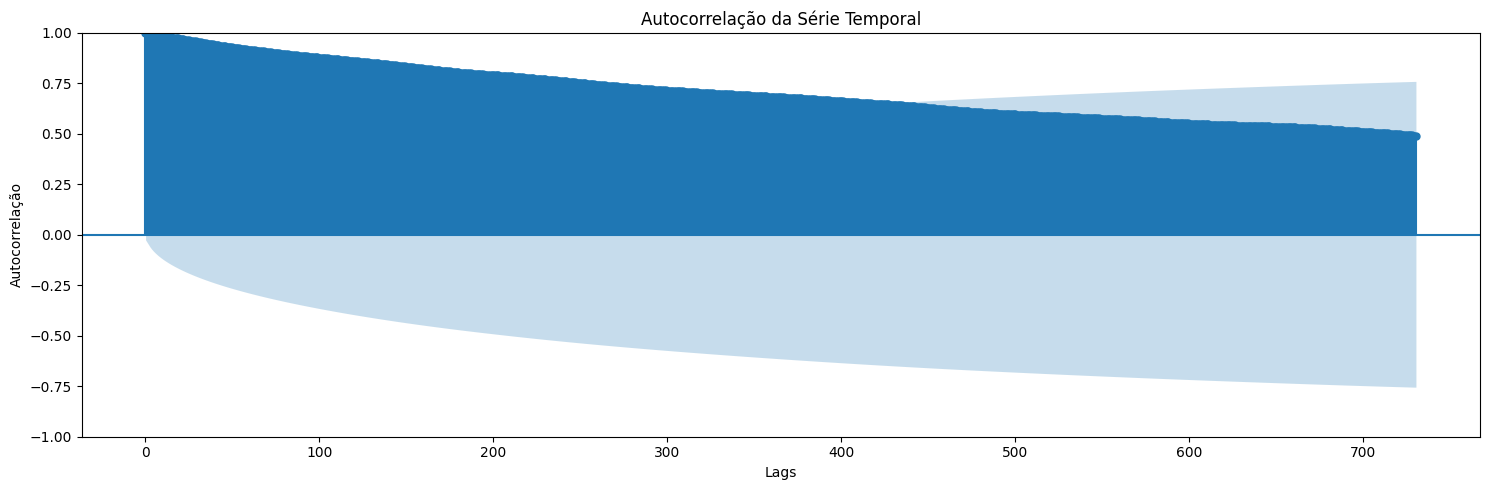

In [ ]:
plot_acf(df['fechamento'])

## Autocorrelação Parcial da Série Temporal (PACF)

In [ ]:
def plot_pacf(df, lags=30, title="Autocorrelação Parcial da Série Temporal"):

    fig, ax = plt.subplots(figsize=(15, 5))

    _plot_pacf(df, lags=lags, ax=ax, alpha=0.05)
    ax.set_title(title)
    ax.set_xlabel("Lags")
    ax.set_ylabel("Autocorrelação Parcial")
    fig.set_tight_layout(True)

    acf_x = sm.tsa.pacf(df, alpha=0.05, nlags=lags)
    acf, ci = acf_x[:2]
    intercept_point = np.where(abs(acf) < (ci[:, 1] - acf))
    if intercept_point[0].size > 0:
        print(
            f"Os coeficientes da função de autocorrelação parcial (ACF) cruzam o limite de significância no lag  {intercept_point[0][0]}"
        )
    else:
        print("Os coeficientes da PACF não cruzam o limite de significância")

Os coeficientes da função de autocorrelação parcial (ACF) cruzam o limite de significância no lag  3


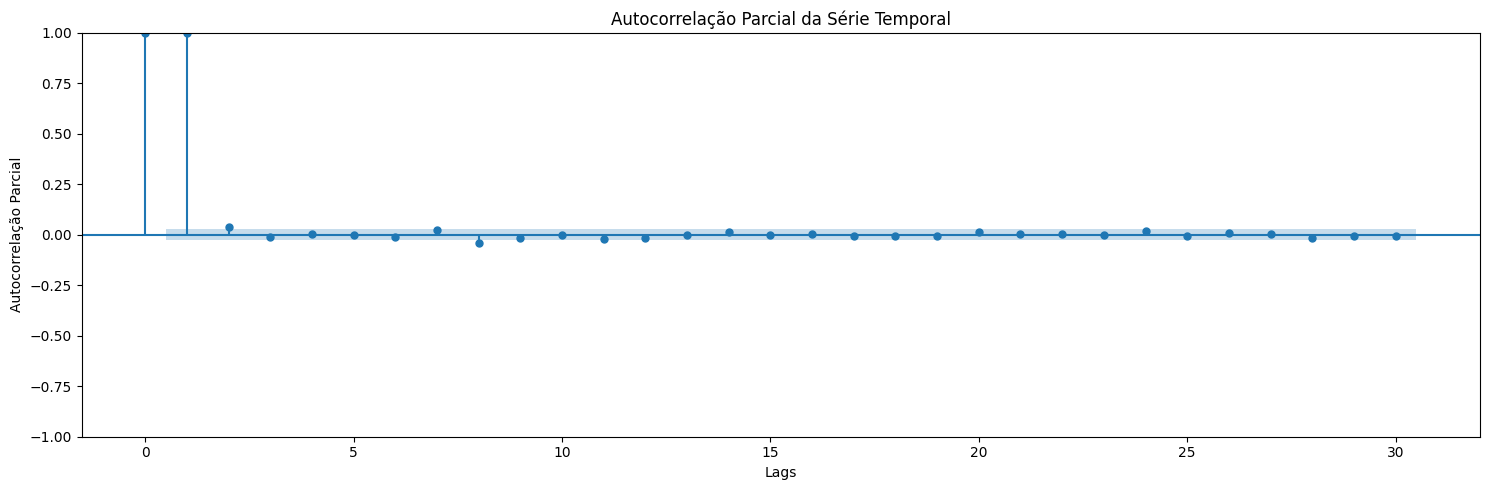

In [ ]:
plot_pacf(df['fechamento'])

## Avaliando a Estacionariedade da Série Temporal

In [ ]:
# Teste Adfuller
adf_result = sm.tsa.adfuller(df["fechamento"])
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print(f"Critical Values: {adf_result[4]}")

if adf_result[1] < 0.05:
    print("A série temporal é estacionária")
else:
    print("A série temporal não é estacionária")

ADF Statistic: -0.8813396975893466
p-value: 0.794055398012611
Critical Values: {'1%': -3.431675776024318, '5%': -2.8621258479427483, '10%': -2.5670818478621267}
A série temporal não é estacionária


## Tornando a Série Temporal Estacionária

In [ ]:
# Diferenciação
adf_result = sm.tsa.adfuller(df["fechamento"].diff().dropna())
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print(f"Critical Values: {adf_result[4]}")

if adf_result[1] < 0.05:
    print("A série temporal é estacionária")
else:
    print("A série temporal não é estacionária")

ADF Statistic: -23.868710793675536
p-value: 0.0
Critical Values: {'1%': -3.431675776024318, '5%': -2.8621258479427483, '10%': -2.5670818478621267}
A série temporal é estacionária


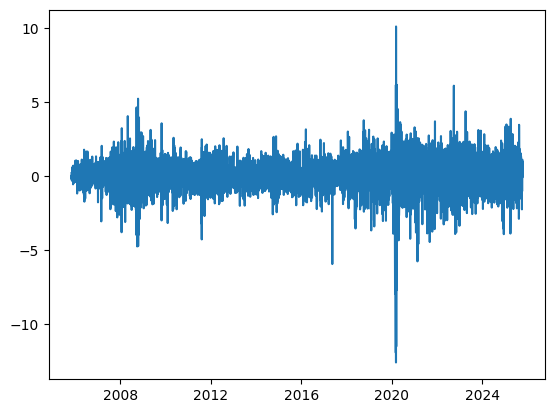

In [ ]:
plt.plot(df['fechamento'].diff().dropna())

## Coeficiente de Regressão

Consiste em um método para levantar os dados de lags, já levantados acima, de forma mais ágil

In [ ]:
# Coeficiente de Regressão
acf_x = sm.tsa.acf(df['fechamento'], alpha=0.05, nlags=730)
acf, ci = acf_x[:2]
# identificação do q pelo ponto de interceptação ao 95% com o acf
q = np.where(abs(acf) < (ci[:, 1] - acf))[0][0]

pacf_x = sm.tsa.pacf(df["fechamento"], alpha=0.05, nlags=30)
pacf, ci = pacf_x[:2]
# identificação do p pelo ponto de interceptação ao 95% com o pacf
p = np.where(abs(pacf) < (ci[:, 1] - pacf))[0][0]

d = 1  # apenas 1 diferenciação foi necessária para tornar a série estacionária

In [ ]:
# parâmetros do modelo ARIMA
print(p, q, d)

3 423 1


## Análise de Sazonalidade

In [ ]:
import pmdarima as pm

In [ ]:
# Determinando Sazonalidade

model = pm.auto_arima(
    df["fechamento"],
    seasonal=True,
    m=12,
    stepwise=True,
)
print(model.summary())
seasonal_order = model.seasonal_order
print(f"Detected Seasonal Order: {seasonal_order}")

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4944
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -7697.354
Date:                Tue, 28 Oct 2025   AIC                          15400.707
Time:                        17:44:48   BIC                          15420.224
Sample:                             0   HQIC                         15407.552
                               - 4944                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0242      0.017      1.428      0.153      -0.009       0.057
ar.L1         -0.0701      0.006    -12.550      0.000      -0.081      -0.059
sigma2         1.3186      0.011    121.853      0.0

## Modelo 1 - SARIMAX

In [ ]:
# Modelo SARIMAX
exog_train = X_train[['abertura_t-1',
 'ano',
 'dia',
 'dia_da_semana',
 'max_t-1',
 'mes',
 'min_t-1',
 'range_diario',
 'range_diario_t-1',
 'rsi',
 'rsi_t-1',
 'sma_20d',
 'sma_20d_t-1',
 'sma_5d',
 'sma_5d_t-1',
 'volume_t-1']]
exog_test = X_test[['abertura_t-1',
 'ano',
 'dia',
 'dia_da_semana',
 'max_t-1',
 'mes',
 'min_t-1',
 'range_diario',
 'range_diario_t-1',
 'rsi',
 'rsi_t-1',
 'sma_20d',
 'sma_20d_t-1',
 'sma_5d',
 'sma_5d_t-1',
 'volume_t-1']]

model = sm.tsa.statespace.SARIMAX(
    y_train.values,
    exog=exog_train,
    order=(
        p,
        d,
        1,
    ),  # q muito grande faz com que o modelo fique muito complexo e lento
    seasonal_order=(0, 0, 0, 12),
)
results = model.fit()

preds = results.get_forecast(steps=len(X_test), exog=exog_test).predicted_mean

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/stat

### Testando o Modelo Sarimax

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


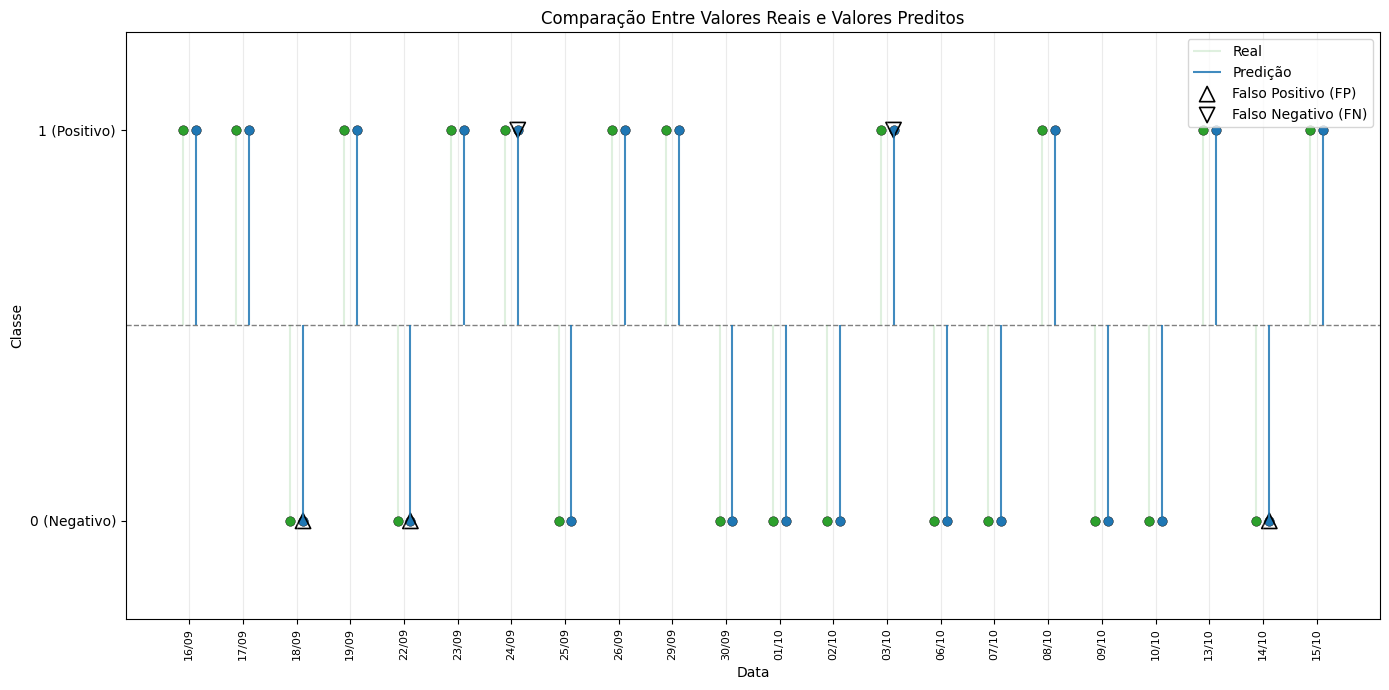


Métricas de Classificação
Accuracy:  0.7727
Precision: 0.7500
Recall:    0.8182
F1-score:  0.7826

Classification report:

              precision    recall  f1-score   support

           0     0.8000    0.7273    0.7619        11
           1     0.7500    0.8182    0.7826        11

    accuracy                         0.7727        22
   macro avg     0.7750    0.7727    0.7723        22
weighted avg     0.7750    0.7727    0.7723        22



In [ ]:
# Gera as previsões contínuas
preds = results.get_forecast(steps=len(X_test), exog=exog_test).predicted_mean
preds = pd.Series(preds.to_numpy(), index=X_test.index, name="yhat")

# Cria variável binária a partir do threshold 0.5
binary_preds = (preds >= 0.5).astype(int)

# Gera o gráfico de visualização das predições desse modelo
grafico_predicao(y_test, binary_preds, df_test)

### Conclusão SARIMAX

Apesar de o modelo atingir a acurácia mínima necessária, sua performance foi inferior ao modelo SVM.

## Modelo 2 - Prophet

In [ ]:
# Carregando a série de dados
file_id = "1wOCuinXsWad-Wf6OxL7LIUcdtRr2xamO"
url = f"https://drive.google.com/uc?export=download&id={file_id}"

df_pf = pd.read_csv(url, sep=',')

In [ ]:
# Renomeação das colunas para padrão e consistência
df_pf = df_pf.rename(columns={
    'Data': 'data', 'Último': 'fechamento', 'Abertura': 'abertura',
    'Máxima': 'max', 'Mínima': 'min', 'Vol.': 'volume', 'Var%': 'var'
})

In [ ]:
# Conversão da coluna 'data' para o tipo datetime
df_pf['data'] = pd.to_datetime(df_pf['data'], format='%d.%m.%Y')

In [ ]:
# Remove e substituição de caracteres
df_pf['var'] = df_pf['var'].str.replace('%','').str.replace(',','.').astype(float)

In [ ]:
# Aplicando a função de conversão na coluna 'volume'
df_pf['volume'] = df_pf['volume'].apply(converter_volume)

In [ ]:
# Tratamento de valor nulo com a mediana
df_pf['volume'] = df_pf['volume'].fillna(df_pf['volume'].median())

In [ ]:
df_pf.head(1)

,data,fechamento,abertura,max,min,volume,var
0,2025-10-15,142.604,141.683,142.905,141.154,1.032000e+10,0.65


In [ ]:
# Indicadores de data
df_pf['ano'] = df_pf['data'].dt.year
df_pf['mes'] = df_pf['data'].dt.month
df_pf['dia'] = df_pf['data'].dt.day
df_pf['dia_da_semana'] = df_pf['data'].dt.dayofweek

In [ ]:
# Indicadores de Média Móvel Simples (SMA)
df_pf['sma_5d'] = df_pf['fechamento'].rolling(window=5).mean()
df_pf['sma_20d'] = df_pf['fechamento'].rolling(window=20).mean()

In [ ]:
# Índice de Força Relativa (RSI)
delta = df_pf['fechamento'].diff(1)
ganho = (delta.where(delta > 0, 0)).rolling(window=14).mean()
perda = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = ganho / perda
df_pf['rsi'] = 100 - (100 / (1 + rs))

In [ ]:
# Range do valor diário
df_pf['range_diario'] = df_pf['max'] - df_pf['min']

### Features(T-1)

In [ ]:
# Features usadas no dia anterior
features_shift = [
    'abertura',
    'max',
    'min',
    'volume',
    'sma_5d',
    'sma_20d',
    'rsi',
    'range_diario'
]

In [ ]:
# Versão shifted das features
for feature in features_shift:
    df_pf[f'{feature}_t-1'] = df_pf[feature].shift(1)

In [ ]:
# Removendo NaN
df_pf.dropna(inplace=True)

### Criação da Variável Alvo

In [ ]:
# Criação do target
df_pf['alvo'] = (df_pf['var'] > 0).astype(int)

In [ ]:
df_pf.head(1)

,data,fechamento,abertura,max,min,volume,var,ano,mes,dia,...,range_diario,abertura_t-1,max_t-1,min_t-1,volume_t-1,sma_5d_t-1,sma_20d_t-1,rsi_t-1,range_diario_t-1,alvo
20,2025-09-17,145.594,144.059,146.331,143.91,9.600000e+09,1.06,2025,9,17,...,2.421,145.594,145.726,144.993,8.370000e+09,145.878,144.0976,65.253775,0.733,1


### Divisão entre Treino e Teste

In [ ]:
train_size = len(df_pf) - 22
df_pf_train = df_pf.iloc[:train_size]
df_pf_test = df_pf.iloc[train_size:]

In [ ]:
print(f"Formato do X_train: {df_pf_train.shape}")
print(f"Formato do X_test: {df_pf_test.shape}")

Formato do X_train: (4922, 24)
Formato do X_test: (22, 24)


In [ ]:
y_pf_train = df_pf_train['alvo']
y_pf_test = df_pf_test['alvo']

In [ ]:
# Remoção de colunas para evitar data leakage
remove_col = [
    'var',
    'fechamento',
    'abertura',
    'max',
    'min',
    'volume'
]

In [ ]:
X_pf_train = df_pf_train.drop(columns=remove_col)
X_pf_test = df_pf_test.drop(columns=remove_col)

In [ ]:
print(f"Formato do X_train: {X_pf_train.shape}")
print(f"Formato do X_test: {X_pf_test.shape}")
print(f"Formato do y_train: {y_pf_train.shape}")
print(f"Formato do y_test: {y_pf_test.shape}")

Formato do X_train: (4922, 18)
Formato do X_test: (22, 18)
Formato do y_train: (4922,)
Formato do y_test: (22,)


### Treinamento de Modelo Prophet

In [ ]:
# Modelo Prophet
train_prophet = X_pf_train.reset_index().rename(columns={"data": "ds", "alvo": "y"})
test_prophet  = X_pf_test.reset_index().rename(columns={"data": "ds", "alvo": "y"})

model = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)

regressores = [
   'abertura_t-1',
 'ano',
 'dia',
 'dia_da_semana',
 'max_t-1',
 'mes',
 'min_t-1',
 'range_diario',
 'range_diario_t-1',
 'rsi',
 'rsi_t-1',
 'sma_20d',
 'sma_20d_t-1',
 'sma_5d',
 'sma_5d_t-1',
 'volume_t-1'
]

for reg in regressores:
    model.add_regressor(reg)
model.fit(train_prophet)

future = model.make_future_dataframe(periods=len(test_prophet))

for reg in regressores:
    future[reg] = pd.concat([train_prophet[reg], test_prophet[reg]], ignore_index=True)

forecast = model.predict(future)

preds_pf = forecast[["ds", "yhat"]].tail(len(test_prophet))
preds_pf = preds_pf.set_index("ds")
y_pf_test = test_prophet.set_index("ds")["y"]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp75g8bqmn/2q7vnb9z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp75g8bqmn/r7ukax59.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54058', 'data', 'file=/tmp/tmp75g8bqmn/2q7vnb9z.json', 'init=/tmp/tmp75g8bqmn/r7ukax59.json', 'output', 'file=/tmp/tmp75g8bqmn/prophet_model7nq99u_d/prophet_model-20251028174509.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:45:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:45:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


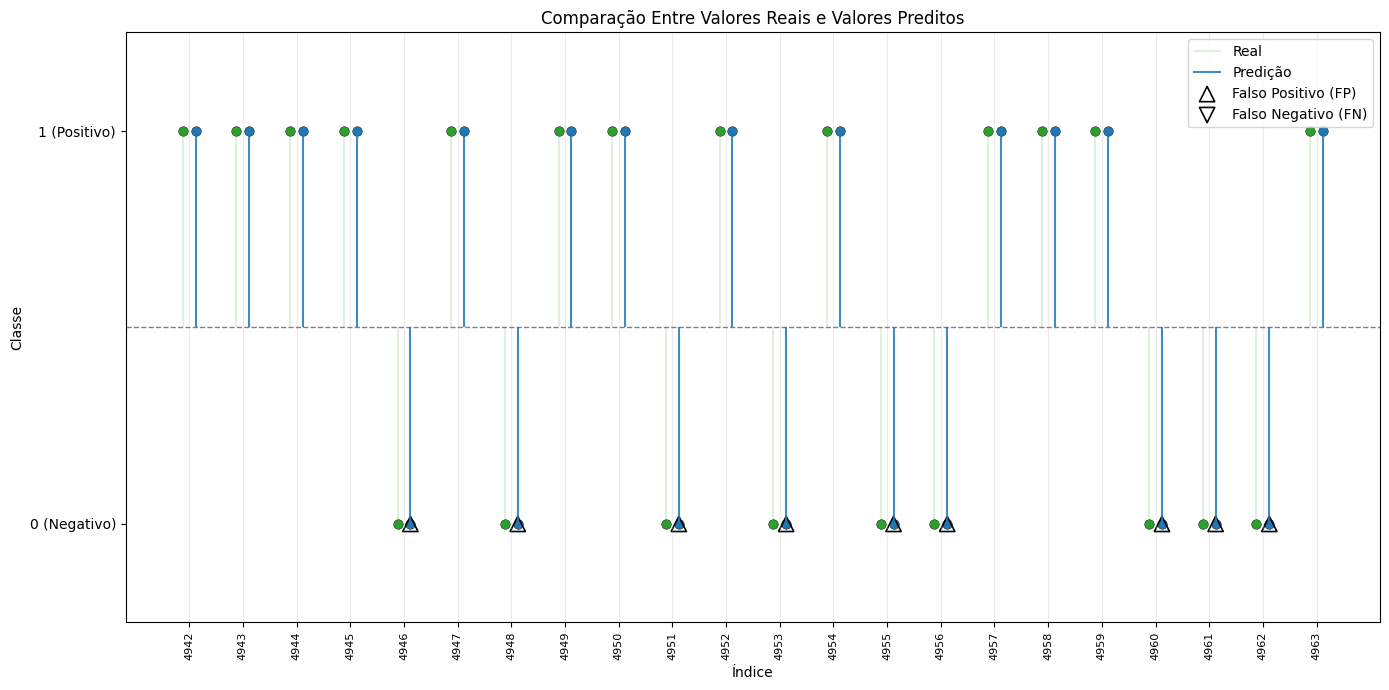


Métricas de Classificação
Accuracy:  0.5909
Precision: 0.5909
Recall:    1.0000
F1-score:  0.7429

Classification report:

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         9
           1     0.5909    1.0000    0.7429        13

    accuracy                         0.5909        22
   macro avg     0.2955    0.5000    0.3714        22
weighted avg     0.3492    0.5909    0.4390        22



In [ ]:
preds = preds_pf["yhat"]
binary_preds = (preds >= 0.5).astype(int)
binary_preds.index = y_pf_test.index
grafico_predicao(y_pf_test, binary_preds, df_pf_test)

### Conclusão - Prophet

Modelo Prophet obteve performance aquém do esperado e não poderá ser utilizado.

# Conclusão do Projeto

O projeto resultou em uma solução preditiva sólida, tecnicamente fundamentada e operacionalmente viável para antecipar a direção diária do Ibovespa.

O modelo SVM otimizado se destacou não apenas por sua alta acurácia (90,91%), mas também por sua consistência, facilidade de integração e baixa necessidade de manutenção.

A combinação entre abordagem supervisionada e modelagem de séries temporais ofereceu um panorama abrangente:

Os classificadores garantem decisões rápidas e eficazes;
As séries temporais fornecem interpretação estrutural e diagnóstico de estabilidade.

Com monitoramento contínuo e integração a sistemas de inteligência financeira, o modelo proposto tem potencial para se tornar um instrumento estratégico de apoio à gestão de riscos, planejamento financeiro e análise de mercado no contexto corporativo.